# Import Libraries

**Originator: Beema Rajan + Zhiqi Zhang +  Shivam Tyagi**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Data processing

## Loading Everyone's data

**Originator: Beema Rajan + Zhiqi Zhang + Shivam Tyagi**

In [2]:
# Loading Beema's data
b_path = "raw_data/beema/cleaned_data/"
csv_files = [file for file in os.listdir(b_path) if file.endswith(".csv")]
dataframes = {}
for file in csv_files:
    file_path = os.path.join(b_path, file)
    df = pd.read_csv(file_path)
    dataframes[file] = df
    print(f"Loaded '{file}' with {df.shape[0]} rows and {df.shape[1]} columns.")

Loaded 'top_40_airplay_cleaned.csv' with 14708 rows and 13 columns.
Loaded 'current_r&b_hip_hop_albums_cleaned.csv' with 14279 rows and 14 columns.
Loaded 'current_country_albums_cleaned.csv' with 5412 rows and 14 columns.
Loaded 'current_pop_albums_cleaned.csv' with 7247 rows and 14 columns.
Loaded 'r&b_hip_hop_airplay_cleaned.csv' with 14702 rows and 13 columns.
Loaded 'dance_electronic_on-demand_cleaned.csv' with 14400 rows and 17 columns.
Loaded 'rock_on-demand_streaming_cleaned.csv' with 14400 rows and 17 columns.
Loaded 'pop_on-demand_streaming_cleaned.csv' with 14400 rows and 17 columns.
Loaded 'top_200_song_consumption_cleaned.csv' with 14197 rows and 19 columns.
Loaded 'video_on-demand_streaming_cleaned.csv' with 14400 rows and 15 columns.
Loaded 'billboard_200_cleaned.csv' with 14400 rows and 21 columns.
Loaded 'heatseekers_cleaned.csv' with 10800 rows and 17 columns.
Loaded 'r&b_hip_hop_albums_cleaned.csv' with 202 rows and 14 columns.
Loaded 'current_rock_albums_cleaned.csv

In [3]:
# Loading Camille's data
c_path = "raw_data/camille/"
csv_files2 = [file for file in os.listdir(c_path) if file.endswith(".csv")]
sentiment_dataframes = {}
for file in csv_files2:
    file_path = os.path.join(c_path, file)
    df = pd.read_csv(file_path)
    sentiment_dataframes[file] = df
    print(f"Loaded '{file}' with {df.shape[0]} rows and {df.shape[1]} columns.")

Loaded 'top_spotify_songs_lyrics.csv' with 1448 rows and 27 columns.
Loaded 'songs_with_attributes_and_lyrics.csv' with 955320 rows and 17 columns.
Loaded 'songs_with_map.csv' with 177 rows and 177 columns.
Loaded 'spotify_aggregated_by_countries.csv' with 72 rows and 7 columns.
Loaded 'top_spotify_songs.csv' with 7522 rows and 25 columns.
Loaded 'songs_with_lyrics_and_timestamps.csv' with 36519092 rows and 3 columns.
Loaded 'universal_top_spotify_songs.csv' with 1486380 rows and 25 columns.


In [4]:
# Loading Shivam's data
s_path = "raw_data/shivam/raw_data/"
csv_files3 = [file for file in os.listdir(s_path) if file.endswith(".csv")]
artists_dataframes = {}
for file in csv_files3:
    file_path = os.path.join(s_path, file)
    df = pd.read_csv(file_path)
    artists_dataframes[file] = df
    print(f"Loaded '{file}' with {df.shape[0]} rows and {df.shape[1]} columns.")

Loaded 'nodes.csv' with 156422 rows and 6 columns.
Loaded 'edges.csv' with 300386 rows and 2 columns.


## Data Preprocessing and Cleaning

### Process data for sentiment analysis

**Originator: Zhiqi Zhang**

In [5]:
#Process data for sentiment analysis
sen_df = sentiment_dataframes['universal_top_spotify_songs.csv']
sen_df['artists_clean'] = sen_df['artists'].str.lower().str.strip()
nodes_df= artists_dataframes['nodes.csv']
nodes_df['name_clean'] = nodes_df['name'].str.lower().str.strip()
merged_df = pd.merge(sen_df,nodes_df,left_on='artists_clean',right_on='name_clean',how='inner')

In [6]:
# Simplify the data
# 1. Remove unnecessary columns
columns_to_drop = ["spotify_id_x", "is_explicit", "duration_ms", "time_signature","artists_clean", "spotify_id_y", "name_y", "name_clean"]
processed_df = merged_df.drop(columns=columns_to_drop)

columns_to_rename = {
    "name_x": "songs",
    "popularity_x": "song_popularity",
    "popularity_y": "artist_popularity"
}
processed_df = processed_df.rename(columns=columns_to_rename)

In [7]:
#2. Remove duplicate columns, keeping only the most recently updated data
processed_df['snapshot_date'] = pd.to_datetime(processed_df['snapshot_date'], errors='coerce')
deduplicated_df = processed_df.sort_values('snapshot_date').drop_duplicates(subset=['songs', 'artists'], keep='last')

print("Deduplicated DataFrame Info:")
print(deduplicated_df.info())

Deduplicated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 7522 entries, 947419 to 0
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   songs               7521 non-null   object        
 1   artists             7521 non-null   object        
 2   daily_rank          7522 non-null   int64         
 3   daily_movement      7522 non-null   int64         
 4   weekly_movement     7522 non-null   int64         
 5   country             7519 non-null   object        
 6   snapshot_date       7522 non-null   datetime64[ns]
 7   song_popularity     7522 non-null   int64         
 8   album_name          7516 non-null   object        
 9   album_release_date  7517 non-null   object        
 10  danceability        7522 non-null   float64       
 11  energy              7522 non-null   float64       
 12  key                 7522 non-null   int64         
 13  loudness            75

In [8]:
# Save the data for analysis to enable repeated use
deduplicated_df.to_csv(os.path.join(c_path,"top_spotify_songs.csv"), index=False)

### Process data for country analysis

**Originator: Zhiqi Zhang**

In [9]:
# Aggregate national data
country_data_filtered = sen_df[['country', 'instrumentalness','liveness','danceability', 'energy', 'valence', 'tempo']]
spotify_aggregated = country_data_filtered.groupby('country').mean().reset_index()
spotify_aggregated.to_csv(os.path.join(c_path,"spotify_aggregated_by_countries.csv"), index=False)

In [10]:
# Load the world map data
map_file_path = os.path.join(c_path,"ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world = gpd.read_file(map_file_path)

In [11]:
# Match the national coverage data with the map data
country_codes_list = spotify_aggregated['country'].unique().tolist()
print("Spotify Aggregated Country Codes List:")
print(country_codes_list)
country_codes_list2 = world['SOV_A3'].unique().tolist()
print(country_codes_list2)

Spotify Aggregated Country Codes List:
['AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR', 'BY', 'CA', 'CH', 'CL', 'CO', 'CR', 'CZ', 'DE', 'DK', 'DO', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JP', 'KR', 'KZ', 'LT', 'LU', 'LV', 'MA', 'MX', 'MY', 'NG', 'NI', 'NL', 'NO', 'NZ', 'PA', 'PE', 'PH', 'PK', 'PL', 'PT', 'PY', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TR', 'TW', 'UA', 'US', 'UY', 'VE', 'VN', 'ZA']
['FJI', 'TZA', 'SAH', 'CAN', 'US1', 'KA1', 'UZB', 'PNG', 'IDN', 'ARG', 'CHL', 'COD', 'SOM', 'KEN', 'SDN', 'TCD', 'HTI', 'DOM', 'RUS', 'BHS', 'GB1', 'NOR', 'DN1', 'FR1', 'TLS', 'ZAF', 'LSO', 'MEX', 'URY', 'BRA', 'BOL', 'PER', 'COL', 'PAN', 'CRI', 'NIC', 'HND', 'SLV', 'GTM', 'BLZ', 'VEN', 'GUY', 'SUR', 'ECU', 'JAM', 'CU1', 'ZWE', 'BWA', 'NAM', 'SEN', 'MLI', 'MRT', 'BEN', 'NER', 'NGA', 'CMR', 'TGO', 'GHA', 'CIV', 'GIN', 'GNB', 'LBR', 'SLE', 'BFA', 'CAF', 'COG', 'GAB', 'GNQ', 'ZMB', 'MWI', 'MOZ', 'SWZ', 'AGO', 'BDI', 'IS1', 'L

In [12]:
country_code_mapping = {
    'AE': 'ARE',  # United Arab Emirates
    'AR': 'ARG',  # Argentina
    'AT': 'AUT',  # Austria
    'AU': 'AUS',  # Australia
    'BE': 'BEL',  # Belgium
    'BG': 'BGR',  # Bulgaria
    'BO': 'BOL',  # Bolivia
    'BR': 'BRA',  # Brazil
    'BY': 'BLR',  # Belarus
    'CA': 'CAN',  # Canada
    'CH': 'CHE',  # Switzerland
    'CL': 'CHL',  # Chile
    'CO': 'COL',  # Colombia
    'CR': 'CRI',  # Costa Rica
    'CZ': 'CZE',  # Czech Republic
    'DE': 'DEU',  # Germany
    'DK': 'DNK',  # Denmark
    'DO': 'DOM',  # Dominican Republic
    'EC': 'ECU',  # Ecuador
    'EE': 'EST',  # Estonia
    'EG': 'EGY',  # Egypt
    'ES': 'ESP',  # Spain
    'FI': 'FIN',  # Finland
    'FR': 'FRA',  # France
    'GB': 'GBR',  # United Kingdom
    'GR': 'GRC',  # Greece
    'GT': 'GTM',  # Guatemala
    'HK': 'HKG',  # Hong Kong
    'HN': 'HND',  # Honduras
    'HU': 'HUN',  # Hungary
    'ID': 'IDN',  # Indonesia
    'IE': 'IRL',  # Ireland
    'IL': 'ISR',  # Israel
    'IN': 'IND',  # India
    'IS': 'ISL',  # Iceland
    'IT': 'ITA',  # Italy
    'JP': 'JPN',  # Japan
    'KR': 'KOR',  # South Korea
    'KZ': 'KAZ',  # Kazakhstan
    'LT': 'LTU',  # Lithuania
    'LU': 'LUX',  # Luxembourg
    'LV': 'LVA',  # Latvia
    'MA': 'MAR',  # Morocco
    'MX': 'MEX',  # Mexico
    'MY': 'MYS',  # Malaysia
    'NG': 'NGA',  # Nigeria
    'NI': 'NIC',  # Nicaragua
    'NL': 'NLD',  # Netherlands
    'NO': 'NOR',  # Norway
    'NZ': 'NZL',  # New Zealand
    'PA': 'PAN',  # Panama
    'PE': 'PER',  # Peru
    'PH': 'PHL',  # Philippines
    'PK': 'PAK',  # Pakistan
    'PL': 'POL',  # Poland
    'PT': 'PRT',  # Portugal
    'PY': 'PRY',  # Paraguay
    'RO': 'ROU',  # Romania
    'SA': 'SAU',  # Saudi Arabia
    'SE': 'SWE',  # Sweden
    'SG': 'SGP',  # Singapore
    'SK': 'SVK',  # Slovakia
    'SV': 'SLV',  # El Salvador
    'TH': 'THA',  # Thailand
    'TR': 'TUR',  # Turkey
    'TW': 'TWN',  # Taiwan
    'UA': 'UKR',  # Ukraine
    'US': 'USA',  # United States
    'UY': 'URY',  # Uruguay
    'VE': 'VEN',  # Venezuela
    'VN': 'VNM',  # Vietnam
    'ZA': 'ZAF',  # South Africa
}


spotify_aggregated['country'] = spotify_aggregated['country'].map(country_code_mapping)

unmapped_countries = spotify_aggregated[spotify_aggregated['country'].isna()]
print("Unmapped countries after mapping:", unmapped_countries)

Unmapped countries after mapping: Empty DataFrame
Columns: [country, instrumentalness, liveness, danceability, energy, valence, tempo]
Index: []


In [13]:
world_merged = world.merge(spotify_aggregated, how='left', left_on='ISO_A3', right_on='country')
world_merged.to_csv(os.path.join(c_path, "songs_with_map.csv"))

### Process data for lyrics analysis

**Originator: Zhiqi Zhang**

In [14]:
lyrics_df = sentiment_dataframes['songs_with_attributes_and_lyrics.csv']
lyrics_df2 = lyrics_df[['name','artists','lyrics']]
lyrics = pd.merge(deduplicated_df,lyrics_df2,left_on=['songs','artists'],right_on=['name','artists'],how='inner')
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   songs               1446 non-null   object        
 1   artists             1446 non-null   object        
 2   daily_rank          1448 non-null   int64         
 3   daily_movement      1448 non-null   int64         
 4   weekly_movement     1448 non-null   int64         
 5   country             1448 non-null   object        
 6   snapshot_date       1448 non-null   datetime64[ns]
 7   song_popularity     1448 non-null   int64         
 8   album_name          1445 non-null   object        
 9   album_release_date  1445 non-null   object        
 10  danceability        1448 non-null   float64       
 11  energy              1448 non-null   float64       
 12  key                 1448 non-null   int64         
 13  loudness            1448 non-null   float64     

In [15]:
lyrics.to_csv(os.path.join(c_path,"top_spotify_songs_lyrics.csv"), index=False)

### Process data for Songs that Stay on the Charts

**Originator: Beema Rajan**

In [16]:
# Top 200 song consumption
top_200_df = dataframes['top_200_song_consumption_cleaned.csv']

# Group by 'Song' and keep the row with the highest 'Weeks On Chart'
unique_songs = top_200_df.loc[top_200_df.groupby('Song')['Weeks On Chart'].idxmax()]
unique_songs = unique_songs.reset_index(drop=True)

# Top 25% of Weeks on Chart
top_songs = unique_songs[unique_songs['Weeks On Chart'] >= 20]

# Bottom 75% of Weeks on Chart
bottom_songs = unique_songs[unique_songs['Weeks On Chart'] < 20]

# Camille's large dataset
all_songs = deduplicated_df.copy()

# Merge two datasets
merged_dataset_top_25 = pd.merge(top_songs, all_songs, how='inner', left_on='Song', right_on='songs')

# Columns to be used for analysis later
song_features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

### **Visualization and analysis**

## Feature distribution of Spotify's hit songs across different countries

**Originator: Zhiqi Zhang**

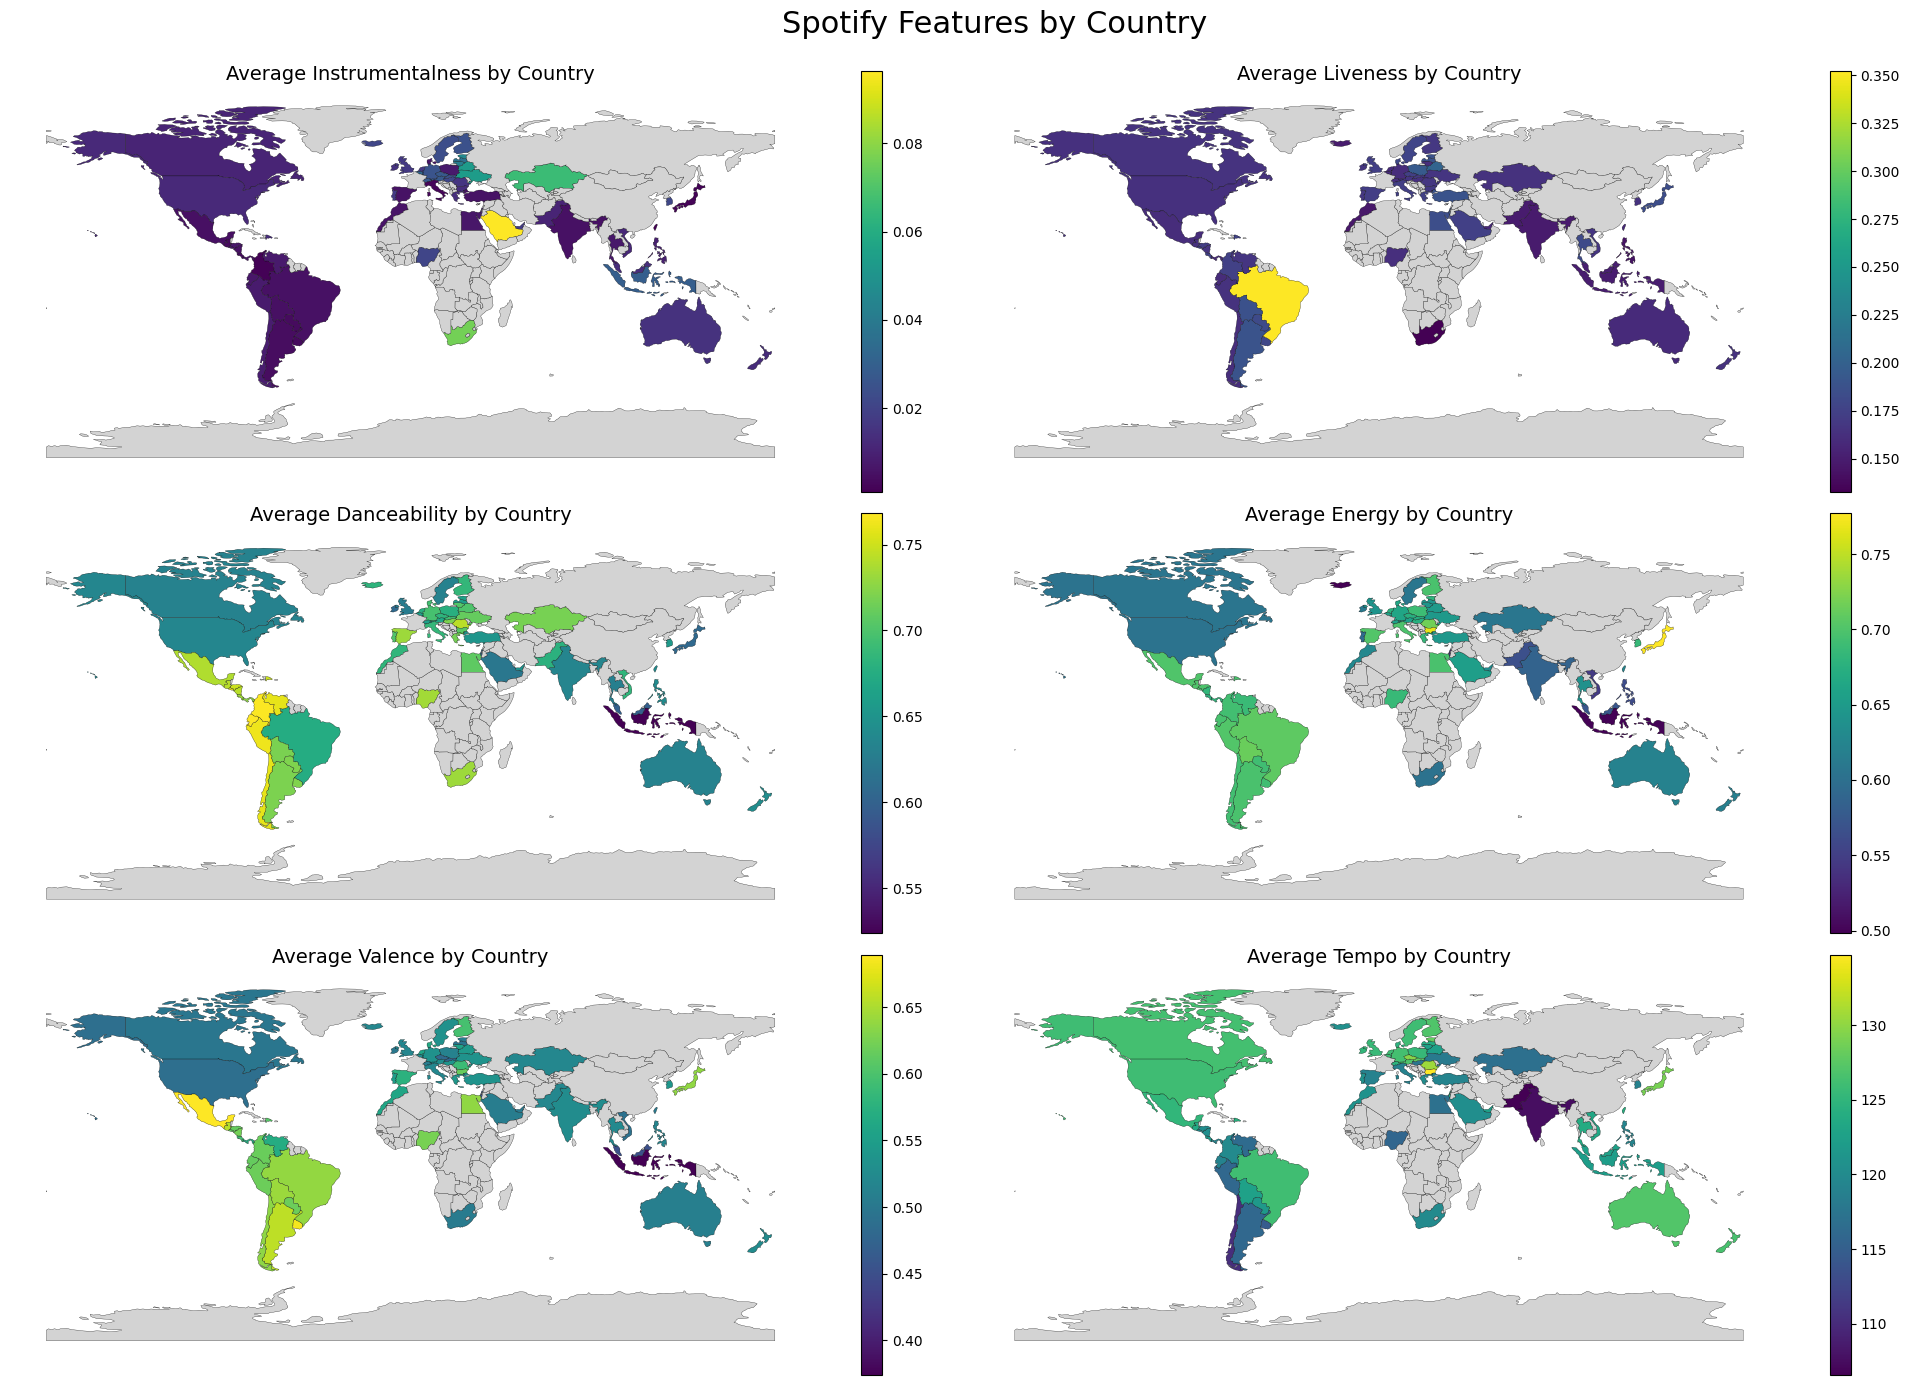

In [17]:
# Define features
features_to_country = ['instrumentalness', 'liveness', 'danceability', 'energy', 'valence', 'tempo']

# Create a figure with subplots (3 rows, 2 columns)
fig, ax = plt.subplots(3, 2, figsize=(20, 15))  
fig.suptitle("Spotify Features by Country", fontsize=22, y=0.92)

# Plot each feature
for i, feature in enumerate(features_to_country):
    row, col = divmod(i, 2)  # Determine the subplot position
    if feature not in world_merged.columns:
        print(f"Feature '{feature}' not found in merged data.")
        continue

    
    world_merged.plot(
        column=feature,
        cmap="viridis",  
        legend=True,  
        ax=ax[row, col],  
        missing_kwds={"color": "lightgrey", "label": "No data"}, 
        edgecolor="black",  
        linewidth=0.2
    )
    ax[row, col].set_title(f"Average {feature.capitalize()} by Country", fontsize=14)
    ax[row, col].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("graphs/spotify_features_by_country.png", dpi=300, bbox_inches='tight')
plt.show()

## Relationship between song features and artist popularity

**Originator: Zhiqi Zhang**

In [18]:
# Aggregate the data to analyze the relationship between artist popularity and the characteristics of their hit songs
artists_df = deduplicated_df.copy()
grouped_df = artists_df.groupby("artists").agg({
    "valence": "mean",
    "danceability": "mean",
    "energy": "mean",
    "liveness": "mean",
    "speechiness": "mean",
    "acousticness": "mean",
    "instrumentalness": "mean",
    "tempo": "mean",
    "artist_popularity": "max",
    "followers": "max",
    "songs": "count"
}).reset_index()
grouped_df.rename(columns={"songs": "song_count"}, inplace=True)
print(grouped_df.describe())

           valence  danceability       energy     liveness  speechiness  \
count  2613.000000   2613.000000  2613.000000  2613.000000  2613.000000   
mean      0.541465      0.645548     0.639125     0.183869     0.095610   
std       0.213435      0.132304     0.166624     0.119441     0.088819   
min       0.000010      0.158000     0.001890     0.026800     0.024200   
25%       0.385333      0.563000     0.535000     0.107000     0.037900   
50%       0.529167      0.656667     0.655889     0.145333     0.057733   
75%       0.699500      0.742000     0.758000     0.225000     0.116000   
max       0.992000      0.982000     0.995000     0.964000     0.766000   

       acousticness  instrumentalness        tempo  artist_popularity  \
count   2613.000000       2613.000000  2613.000000        2613.000000   
mean       0.297052          0.020632   123.150644          50.699579   
std        0.241768          0.095731    23.838835          18.941608   
min        0.000013          0.0

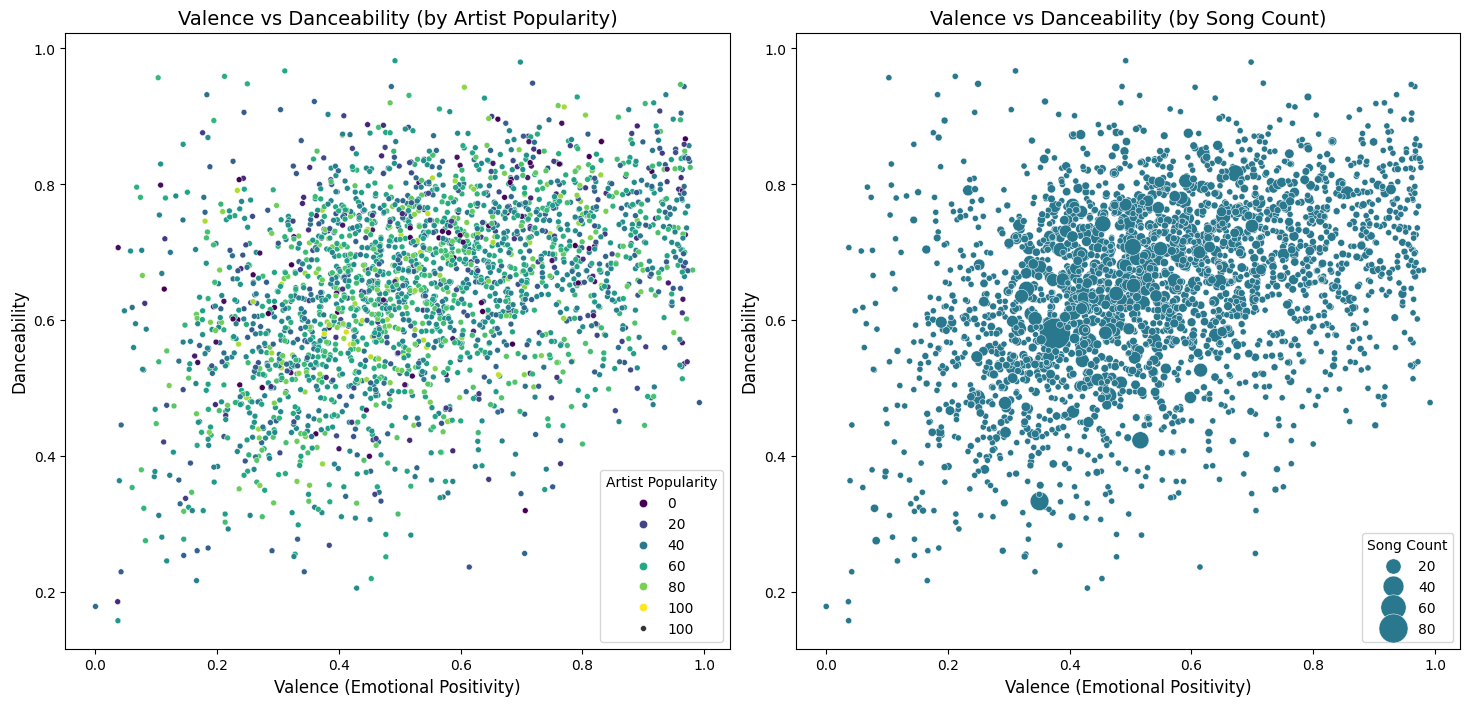

In [19]:
#Visualizing the Relationship Between Valence, Danceability, Artist Popularity, and Song Count
plt.figure(figsize=(18, 8)) 

# Left plot: Color represents artist popularity
plt.subplot(1, 2, 1) 
sns.scatterplot(
    data=grouped_df,
    x="valence", y="danceability",
    hue="artist_popularity", palette="viridis",  # Use color to show artist popularity
    size=100,  # Fix point size
    legend="brief"
)
plt.title("Valence vs Danceability (by Artist Popularity)", fontsize=14) 
plt.xlabel("Valence (Emotional Positivity)", fontsize=12)
plt.ylabel("Danceability", fontsize=12)
plt.legend(title="Artist Popularity", loc="lower right")

# Right plot: Size represents song count
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=grouped_df,
    x="valence", y="danceability",
    size="song_count", sizes=(20, 500),  # Use size to represent song count
    hue=None, color="#2a788e",  # Use a fixed color
    legend="brief"
)
plt.title("Valence vs Danceability (by Song Count)", fontsize=14)
plt.xlabel("Valence (Emotional Positivity)", fontsize=12)
plt.ylabel("Danceability", fontsize=12)
plt.legend(title="Song Count", loc="lower right")  

# Adjust the spacing between plots to avoid overlap
plt.subplots_adjust(wspace=0.1)
plt.savefig("graphs/01_spotify_features_by_artists.png", dpi=300, bbox_inches='tight')
plt.show()

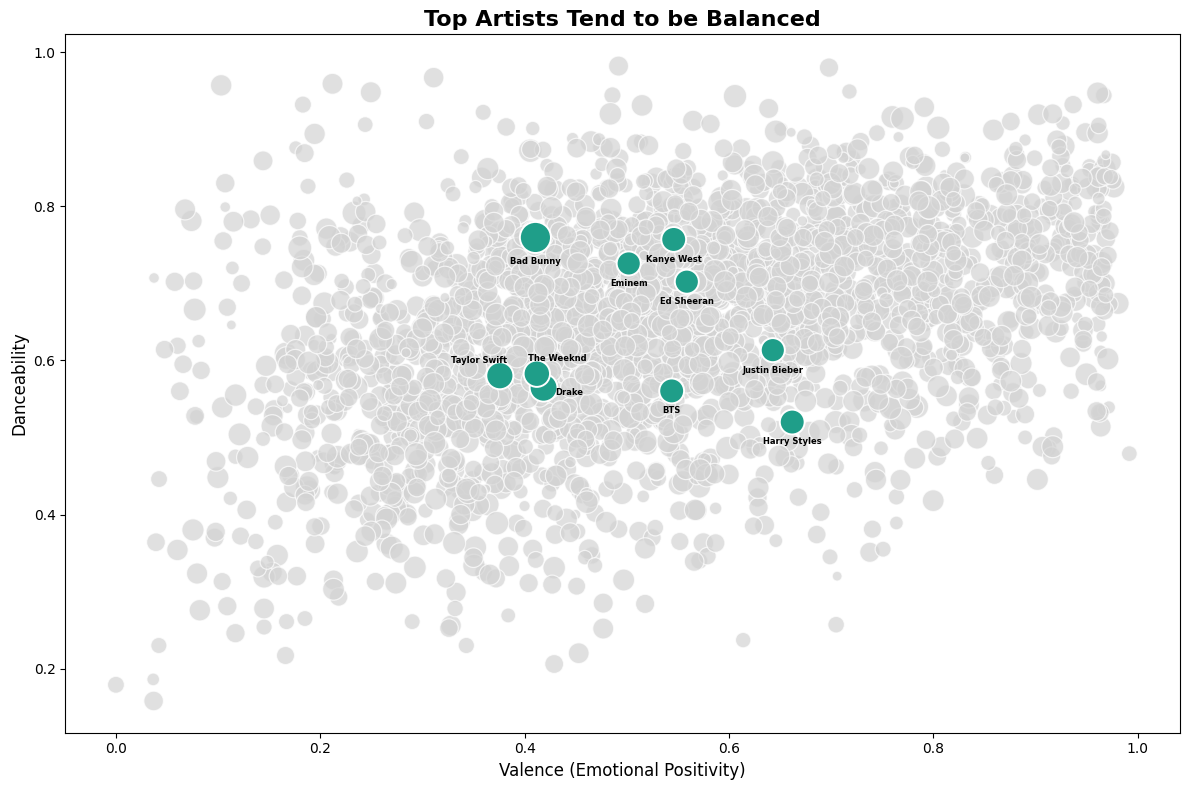

In [20]:
# Get into Depth
top_10_artists = grouped_df.nlargest(10, "artist_popularity")
# Add a new column to identify the top 10 artists
grouped_df["highlight"] = grouped_df["artists"].apply(lambda x: "Top 10" if x in top_10_artists["artists"].values else "Others")

# Plot all points as the base layer
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=grouped_df[grouped_df["highlight"] == "Others"],
    x="valence",
    y="danceability",
    size="artist_popularity",
    sizes=(50, 300),
    color="lightgray",
    alpha=0.7,
    legend=None
)

# Plot the top 10 artists as a highlighted layer
sns.scatterplot(
    data=grouped_df[grouped_df["highlight"] == "Top 10"],
    x="valence",
    y="danceability",
    size="artist_popularity",
    sizes=(300, 500),
    color="#1f9e89", # color from viridis palette
    alpha=1.0,
    legend=None
)

# Annotate the top 10 artists with their names, adjusting positions to avoid overlaps
for _, row in top_10_artists.iterrows():
    # Adjust text position dynamically
    if row["artists"] == "Drake":
        x_offset = 0.025  # Adjust X position
        y_offset = 0  # Adjust Y position
    elif row["artists"] == "Taylor Swift":
        x_offset = -0.02
        y_offset = 0.025
    elif row["artists"] == "The Weeknd":
        x_offset = 0.02
        y_offset = 0.025
    elif row["artists"] == "Bad Bunny":
        x_offset = 0
        y_offset = -0.025
    else:
        x_offset = 0
        y_offset = -0.02  # Default offset for non-overlapping artists
    
    plt.text(
        row["valence"] + x_offset,  # Add X offset
        row["danceability"] + y_offset,  # Add Y offset
        row["artists"],
        fontsize=6,
        weight="bold",
        color="black",
        ha="center",
        va="top"
    )

# Customize plot appearance
plt.title("Top Artists Tend to be Balanced", weight='bold', fontsize=16)
plt.xlabel("Valence (Emotional Positivity)", fontsize=12)
plt.ylabel("Danceability", fontsize=12)
plt.tight_layout()
plt.savefig("graphs/02_spotify_features_by_artists.png", dpi=300, bbox_inches='tight')
plt.show()


## Word Cloud of Hit Songs

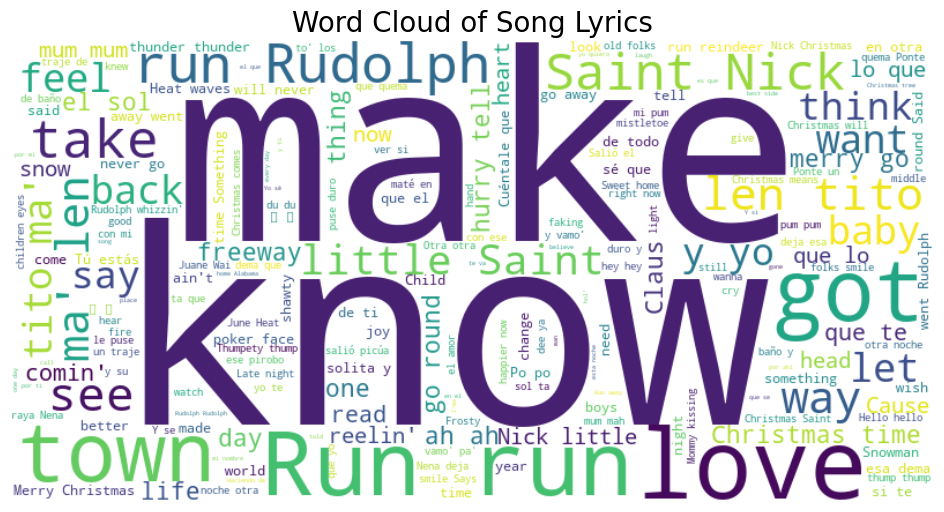

In [21]:
# Define additional stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["oh", "na", "yeah", "ha", "ooh", "gotta", "la", "boy", "girl", "Santa"])

# Combine all lyrics into a single string
lyrics_text = " ".join(lyrics["lyrics"].dropna())

# Create a WordCloud object with custom configurations
wordcloud = WordCloud(
    width=800,          
    height=400,         
    background_color="white",  
    colormap="viridis",  
    max_words=200,      
    stopwords=custom_stopwords,
    random_state=42  # Set random seed for reproducibility
).generate(lyrics_text)

# Visualize the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")  # Display the word cloud with smooth interpolation
plt.axis("off")
plt.title("Word Cloud of Song Lyrics", fontsize=20)
plt.savefig("graphs/spotify_lyrics_wordcloud.png", dpi=300, bbox_inches='tight')
plt.show()

## Properties of Songs that Stay on the Charts

**Originator: Beema Rajan**

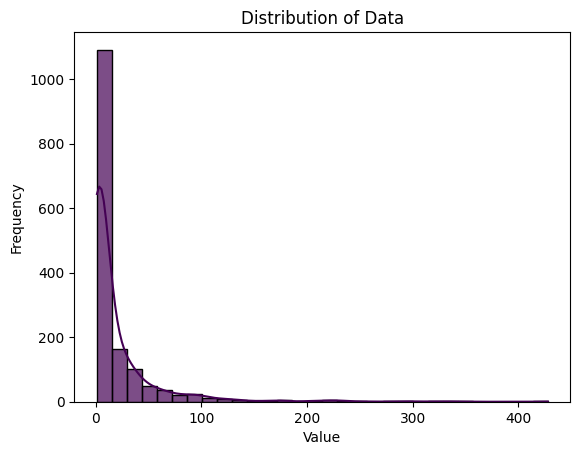

Summary stats:
 count    1543.000000
mean       19.156189
std        38.582145
min         1.000000
25%         1.000000
50%         4.000000
75%        20.000000
max       428.000000
Name: Weeks On Chart, dtype: float64


In [22]:
## Distribution of number of Weeks On Chart

# Data
data = unique_songs['Weeks On Chart']

# Create the plot
# plt.figure(figsize=(16, 8)) # Change if needed
sns.histplot(data, bins=30, kde=True, color='#440154', alpha=0.7)  # kde=True adds a density curve
plt.title('Distribution of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.savefig("graphs/01_properties_of_songs_on_chart.png", dpi=300, bbox_inches='tight')
plt.show()

# Summary stats of distribution
print('Summary stats:\n', data.describe())

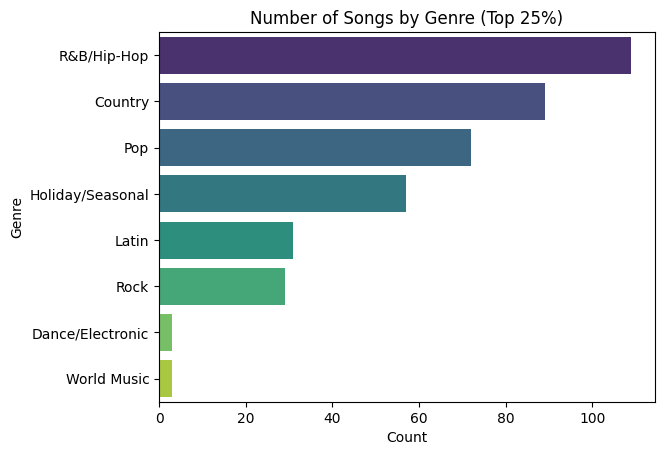

In [23]:
## Count of Genres in the Top 25% of Weeks On Chart

data_genre = top_songs.groupby('Genre')['Song'].count()

# Reset index to convert the Series to a DataFrame
data_genre_df = data_genre.reset_index()
data_genre_df.columns = ['Genre', 'Count']
data_genre_df = data_genre_df.sort_values(by='Count', ascending=False)

# Create the bar plot
sns.barplot(x='Count', y='Genre', data=data_genre_df, hue='Genre', palette='viridis', dodge=False)

# Add title and labels
# plt.figure(figsize=(16, 8)) # Change if needed
plt.title('Number of Songs by Genre (Top 25%)')
plt.xlabel('Count')
plt.ylabel('Genre')

# Show the plot
plt.savefig("graphs/02_properties_of_songs_on_chart.png", dpi=300, bbox_inches='tight')
plt.show()

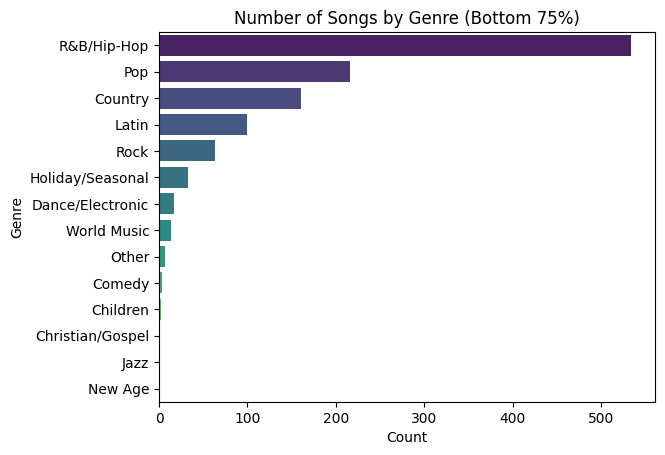

In [24]:
## Count of Genres in the Bottom 75% of Weeks On Chart

data_genre = bottom_songs.groupby('Genre')['Song'].count()

# Reset index to convert the Series to a DataFrame
data_genre_df = data_genre.reset_index()
data_genre_df.columns = ['Genre', 'Count']
data_genre_df = data_genre_df.sort_values(by='Count', ascending=False)

# Create the bar plot
sns.barplot(x='Count', y='Genre', data=data_genre_df, hue='Genre', palette='viridis', dodge=False)

# Add title and labels
# plt.figure(figsize=(16, 8)) # Change if needed
plt.title('Number of Songs by Genre (Bottom 75%)')
plt.xlabel('Count')
plt.ylabel('Genre')

# Show the plot
plt.savefig("graphs/03_properties_of_songs_on_chart.png", dpi=300, bbox_inches='tight')
plt.show()

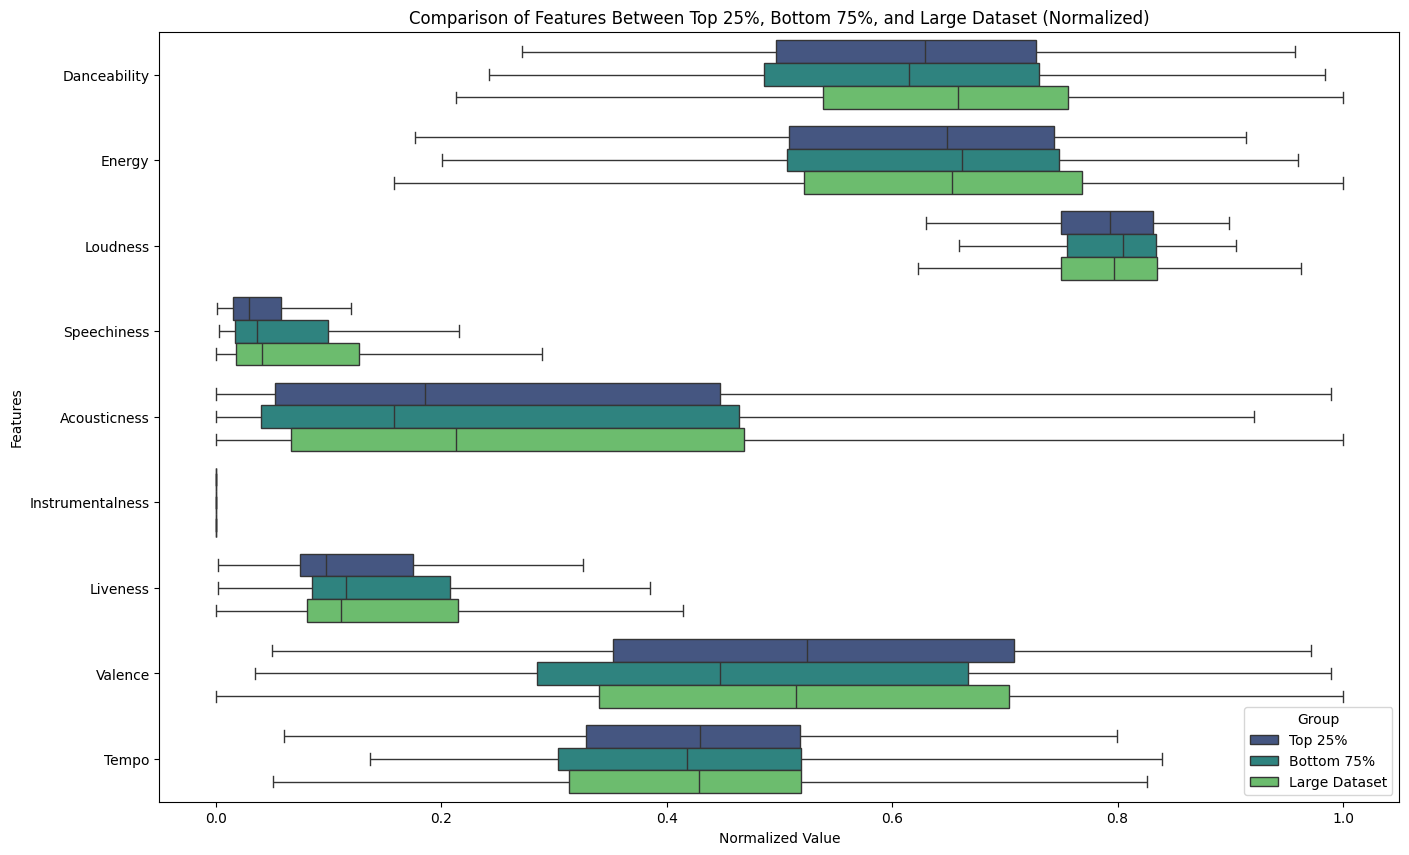

In [25]:
## Similarity of all three sets

# Combine all datasets before normalization
top_songs_merged = merged_dataset_top_25[song_features]
bottom_songs_merged = all_songs.loc[all_songs['songs'].isin(bottom_songs['Song']), song_features]
large_dataset = all_songs[song_features]

# Ensure consistent normalization
all_data = pd.concat([top_songs_merged, bottom_songs_merged, large_dataset])

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(all_data), columns=song_features)

# Split back into respective groups
normalized_top_songs = normalized_data.iloc[:len(top_songs_merged), :].copy()
normalized_bottom_songs = normalized_data.iloc[len(top_songs_merged):len(top_songs_merged) + len(bottom_songs_merged), :].copy()
normalized_large_dataset = normalized_data.iloc[len(top_songs_merged) + len(bottom_songs_merged):, :].copy()

# Melt datasets to make them easier to visualize
top_songs_melted = normalized_top_songs.melt(var_name='Feature', value_name='Value')
bottom_songs_melted = normalized_bottom_songs.melt(var_name='Feature', value_name='Value')
large_dataset_melted = normalized_large_dataset.melt(var_name='Feature', value_name='Value')

# Add a group column
top_songs_melted['Group'] = 'Top 25%'
bottom_songs_melted['Group'] = 'Bottom 75%'
large_dataset_melted['Group'] = 'Large Dataset'

# Combine the datasets
combined_data = pd.concat([top_songs_melted, bottom_songs_melted, large_dataset_melted])

# Capitalize the first letter of each feature
combined_data['Feature'] = combined_data['Feature'].str.capitalize()

# Create box plots
plt.figure(figsize=(16, 10))
sns.boxplot(
    data=combined_data, 
    x='Value', 
    y='Feature', 
    hue='Group',
    showfliers=False, # Remove outliers
    palette='viridis'
)
plt.title(r'Comparison of Features Between Top 25%, Bottom 75%, and Large Dataset (Normalized)')
plt.xlabel('Normalized Value')
plt.ylabel('Features')
plt.savefig("graphs/04_properties_of_songs_on_chart.png", dpi=300, bbox_inches='tight')
plt.show()

## Genres and Total Activity

**Originator: Beema Rajan**

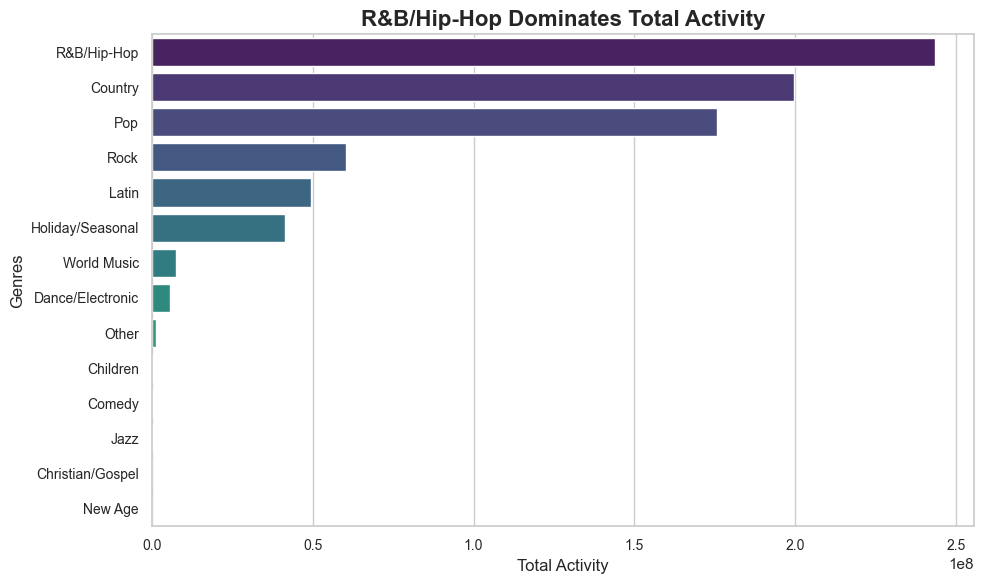

In [26]:
## Bar graph for Genres vs. Total Activity

activity_by_genre = top_200_df.groupby('Genre')['TW Total Activity'].sum().sort_values(ascending=False)

# Convert Series to DataFrame for Seaborn
activity_df = activity_by_genre.reset_index()
activity_df.columns = ['Genre', 'Total Activity']

# Seaborn barplot template
def create_bar_chart(data, x_column, y_column, title, x_label, y_label):
    sns.set(style="whitegrid")  # Set the style for the plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    
    # Create the barplot
    sns.barplot(data=data, x=x_column, y=y_column, hue=y_column, palette="viridis")
    
    # Add customizations
    plt.title(title, fontsize=16, weight='bold')  # Set the title
    plt.xlabel(x_label, fontsize=12)  # Set x-axis label
    plt.ylabel(y_label, fontsize=12)  # Set y-axis label
    plt.xticks(fontsize=10)  # Adjust x-axis ticks
    plt.yticks(fontsize=10)  # Adjust y-axis ticks
    plt.tight_layout()  # Adjust layout to fit nicely
    
    # Show the plot
    plt.savefig(f"graphs/01_genres_with_acitivity.png", dpi=300, bbox_inches='tight')
    plt.show()

# Use the template
create_bar_chart(
    data=activity_df,
    x_column='Total Activity',
    y_column='Genre',
    title='R&B/Hip-Hop Dominates Total Activity',
    x_label='Total Activity',
    y_label='Genres'
)

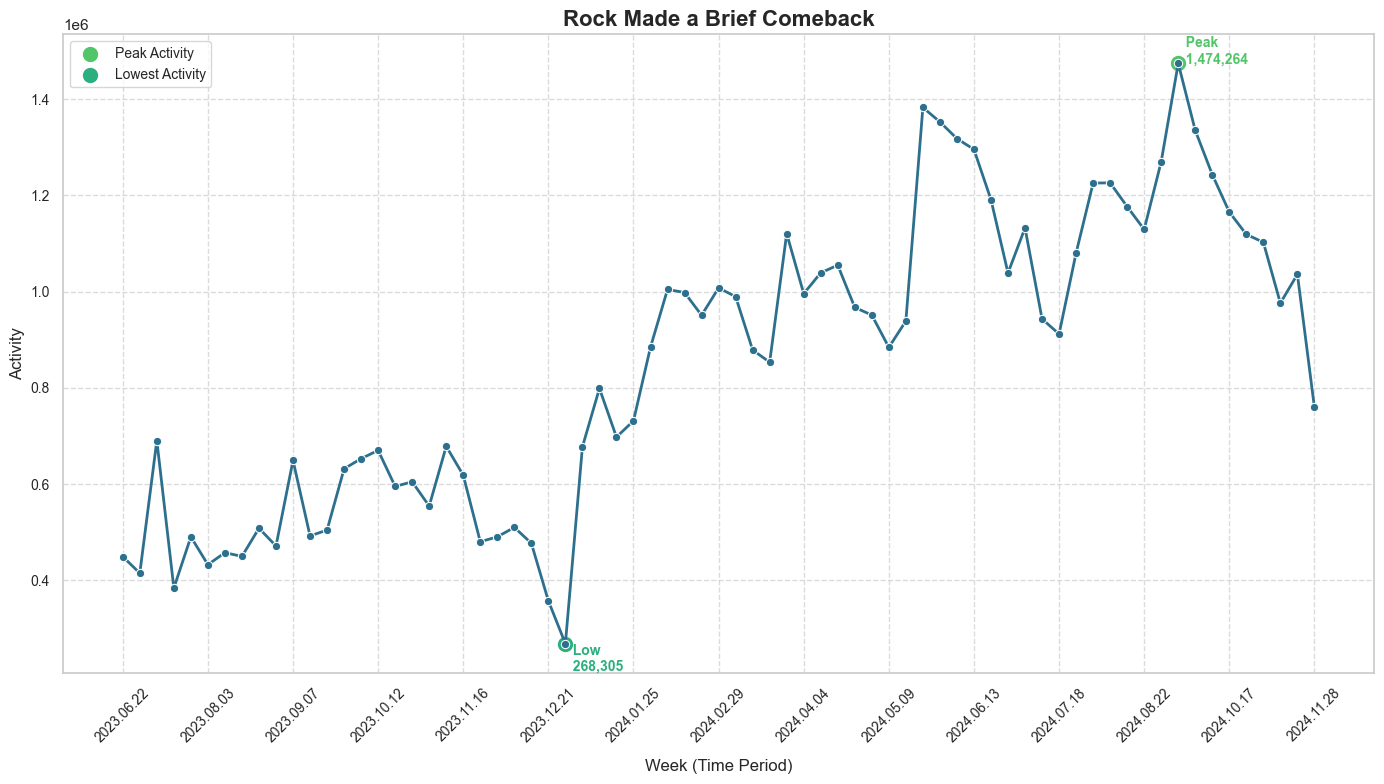

In [27]:
## Line graph for Rock Activity over Time

rock_over_time = top_200_df[top_200_df['Genre'] == 'Rock'].groupby('week_of')['TW Total Activity'].sum()

# Convert Series to DataFrame for Seaborn
rock_over_time_df = rock_over_time.reset_index()
rock_over_time_df.columns = ['Week', 'Total Activity']

def create_line_graph(data, x_column, y_column, title, x_label, y_label):
    sns.set(style="whitegrid") 
    plt.figure(figsize=(14, 8)) 
    
    # Plot the line graph
    sns.lineplot(
        data=data,
        x=x_column,
        y=y_column,
        marker='o',
        color='#2d708e',
        linewidth=2
    )
    
    # Highlight special points (e.g., peaks and troughs)
    max_point = data[data[y_column] == data[y_column].max()]
    min_point = data[data[y_column] == data[y_column].min()]
    plt.scatter(max_point[x_column], max_point[y_column], color='#52c569', s=100, label='Peak Activity')
    plt.scatter(min_point[x_column], min_point[y_column], color='#2ab07f', s=100, label='Lowest Activity')
    
    # Annotate special points
    for _, row in max_point.iterrows():
        plt.text(row[x_column], row[y_column], f'  Peak\n  {int(row[y_column]):,}', color='#52c569', fontsize=10, weight='bold', ha='left')
    for _, row in min_point.iterrows():
        plt.text(row[x_column], row[y_column], f'  Low\n  {int(row[y_column]):,}', color='#2ab07f', fontsize=10, weight='bold', ha='left', va='top')

    # Optimize x-axis ticks (e.g., show every 5th week)
    tick_step = 5
    ticks = data[x_column][::tick_step]
    plt.xticks(ticks=ticks, labels=ticks, fontsize=10, rotation=45)
    
    # Add customizations
    plt.title(title, fontsize=16, weight='bold')  
    plt.xlabel(x_label, fontsize=12, labelpad=10) 
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(fontsize=10, rotation=45)  
    plt.yticks(fontsize=10)
    
    # Add a legend
    plt.legend(loc='upper left', fontsize=10)
    
    # Add grid and tight layout
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.savefig(f"graphs/02_genres_with_acitivity.png", dpi=300, bbox_inches='tight')
    plt.show()

# Use the updated template
create_line_graph(
    data=rock_over_time_df,
    x_column='Week',
    y_column='Total Activity',
    title='Rock Made a Brief Comeback',
    x_label='Week (Time Period)',
    y_label='Activity'
)

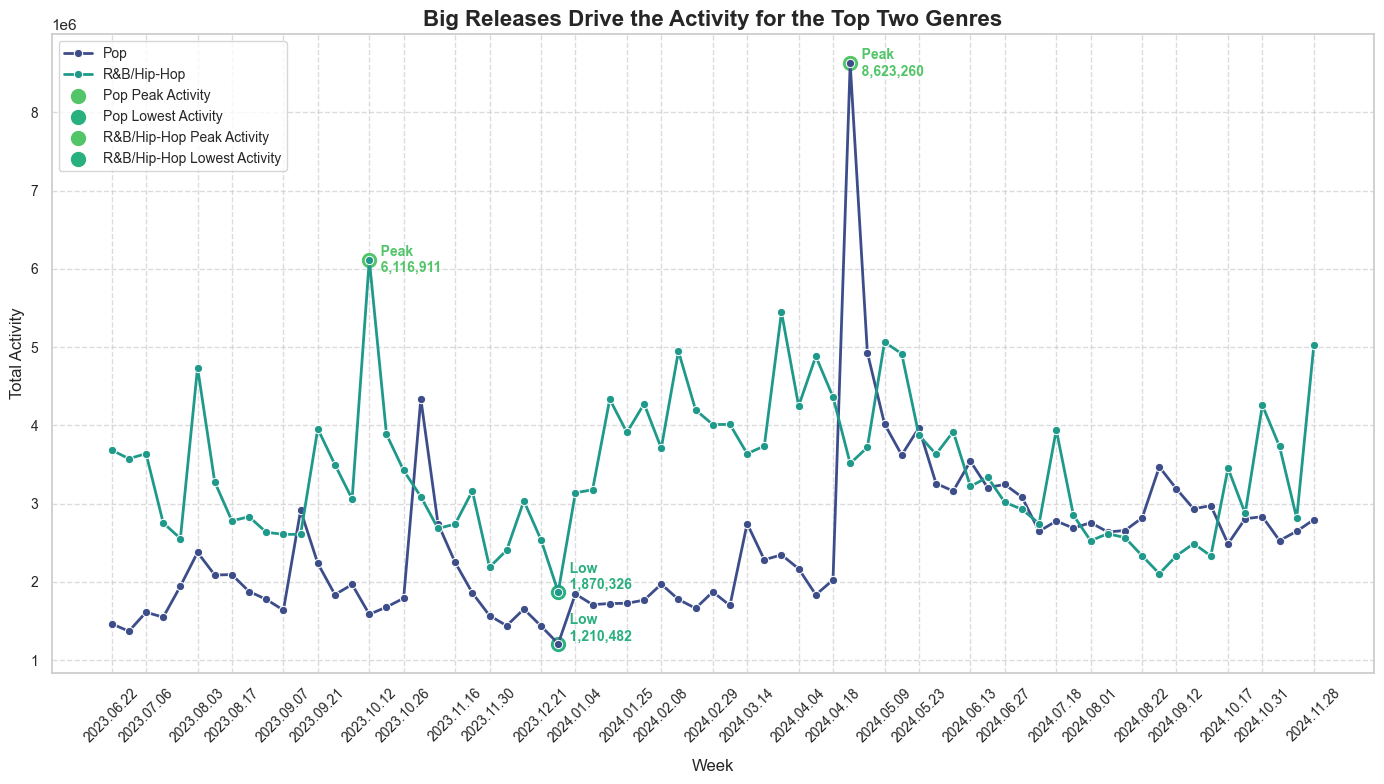

In [28]:
# Group data by week_of and Genre
activity_over_time = top_200_df[top_200_df['Genre'].isin(['Pop', 'R&B/Hip-Hop'])].groupby(['week_of', 'Genre'])['TW Total Activity'].sum().reset_index()

def create_multi_genre_line_graph(data, x_column, y_column, hue_column, title, x_label, y_label):
    sns.set(style="whitegrid")  
    plt.figure(figsize=(14, 8))  

    # Create the line plot with hue for multiple lines
    sns.lineplot(
        data=data, 
        x=x_column, 
        y=y_column, 
        hue=hue_column, 
        marker='o',
        linewidth=2,
        palette=['#3d4d8a', '#1f998a']
    )

    # Highlight peak and lowest points for each genre
    for genre in data[hue_column].unique():
        genre_data = data[data[hue_column] == genre]
        max_point = genre_data[genre_data[y_column] == genre_data[y_column].max()]
        min_point = genre_data[genre_data[y_column] == genre_data[y_column].min()]
        
        # Scatter points for peak and lowest
        plt.scatter(
            max_point[x_column],
            max_point[y_column],
            color='#52c569',
            s=100,
            label=f'{genre} Peak Activity'
        )
        plt.scatter(
            min_point[x_column],
            min_point[y_column],
            color='#2ab07f',
            s=100,
            label=f'{genre} Lowest Activity'
        )
        
        # Annotate the points
        for _, row in max_point.iterrows():
            plt.text(
                row[x_column], 
                row[y_column], 
                f'   Peak\n   {int(row[y_column]):,}', 
                color='#52c569',
                fontsize=10, 
                weight='bold', 
                ha='left',  # Align text to the left
                va='center',  # Center vertically
                #bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  # Add a background box
            )
        for _, row in min_point.iterrows():
            plt.text(
                row[x_column], 
                row[y_column], 
                f'   Low\n   {int(row[y_column]):,}', 
                color='#2ab07f', 
                fontsize=10, 
                weight='bold', 
                ha='left',  # Align text to the left
                va='bottom',  # Center vertically
                #bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  # Add a background box
            )

    # Optimize x-axis ticks (e.g., show every 5th week)
    tick_step = 5
    ticks = data[x_column][::tick_step]
    plt.xticks(ticks=ticks, labels=ticks, fontsize=10, rotation=45)

    # Add customizations
    plt.title(title, fontsize=16, weight='bold')  # Set the title
    plt.xlabel(x_label, fontsize=12, labelpad=10)  # Set x-axis label
    plt.ylabel(y_label, fontsize=12)  # Set y-axis label
    plt.yticks(fontsize=10)  # Adjust y-axis ticks
    plt.legend(loc='upper left', fontsize=10)  # Add legend
    plt.grid(visible=True, linestyle='--', alpha=0.7)  # Add grid
    plt.tight_layout()  # Adjust layout to fit nicely
    
    # Show the plot
    plt.savefig(f"graphs/03_genres_with_acitivity.png", dpi=300, bbox_inches='tight')
    plt.show()

# Use the updated template
create_multi_genre_line_graph(
    data=activity_over_time,
    x_column='week_of',
    y_column='TW Total Activity',
    hue_column='Genre',
    title='Big Releases Drive the Activity for the Top Two Genres',
    x_label='Week',
    y_label='Total Activity'
)

## Seasonality of Genres
**Originator: Shivam Tyagi**

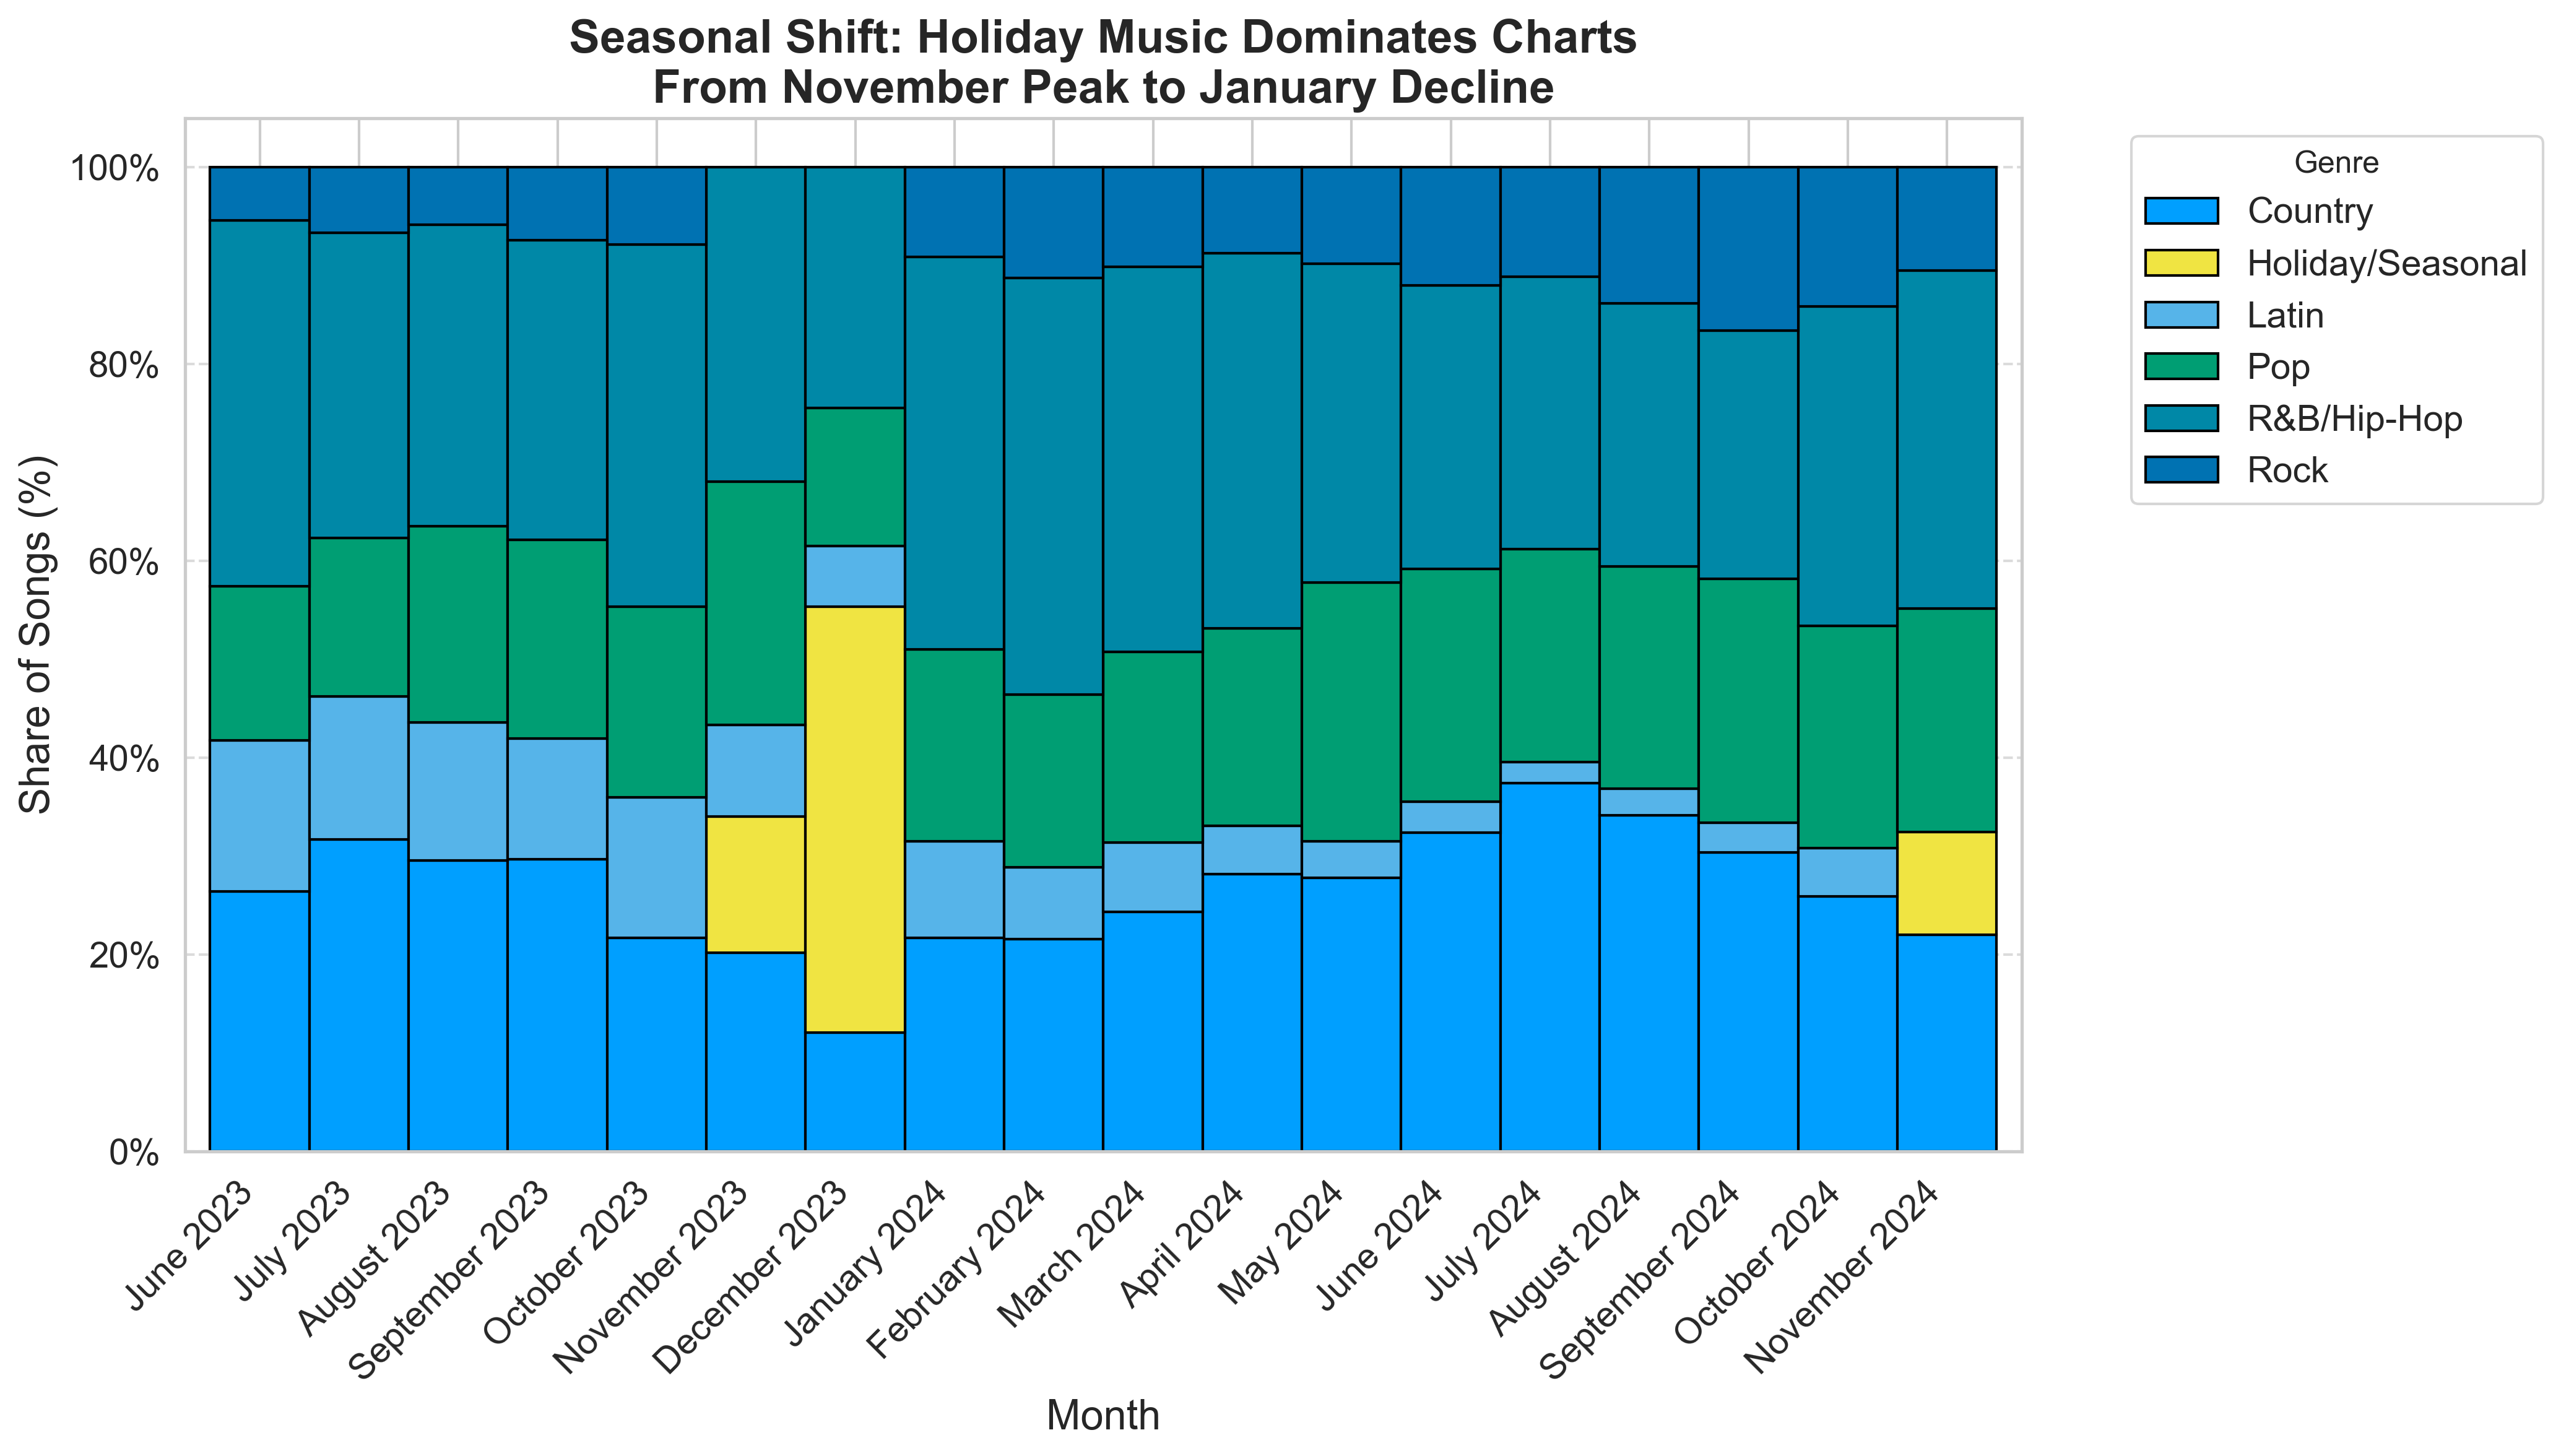

In [29]:
# Retrieve the top 200 songs data
top_200_songs = dataframes['top_200_song_consumption_cleaned.csv']

# Ensure 'week_of' column is in datetime format
if 'week_of' in top_200_songs.columns:
    top_200_songs['week_of'] = pd.to_datetime(top_200_songs['week_of'], format='%Y.%m.%d')
else:
    raise KeyError("'week_of' column is missing from the dataset")

# Group by 'week_of' and get the most common genre for each week
most_common_genre_per_week = top_200_songs.groupby('week_of')['Genre'].agg(lambda x: x.mode()[0])

# Display the result
most_common_genre_per_week

# Extract month from week_of and create monthly groups
top_200_songs['month'] = top_200_songs['week_of'].dt.to_period('M')

# Create pivot table with monthly aggregation
genre_counts_per_month = top_200_songs.pivot_table(index='month', 
                                                  columns='Genre', 
                                                  aggfunc='size', 
                                                  fill_value=0)

# For each month, keep only top 5 genres and set others to 0
top_5_monthly = pd.DataFrame(index=genre_counts_per_month.index, columns=genre_counts_per_month.columns)
for month in genre_counts_per_month.index:
    month_data = genre_counts_per_month.loc[month]
    
    # Get top 5 genres for this month
    top_5_genres = month_data.nlargest(5)
    
    # Create a new row with only top 5 genres
    new_row = month_data.copy()
    new_row[~new_row.index.isin(top_5_genres.index)] = 0
    top_5_monthly.loc[month] = new_row

# Convert to percentages
genre_percentages = top_5_monthly.div(top_5_monthly.sum(axis=1), axis=0) * 100

# Remove columns that are all zeros (genres that never made top 5)
genre_percentages = genre_percentages.loc[:, (genre_percentages != 0).any(axis=0)]
# Define custom colors for genres using a colorblind-friendly palette
genre_colors = {
    'Country': '#009FFF',     
    'Latin': '#56B4E9',       
    'Pop': '#009E73',         
    'R&B/Hip-Hop': '#0088A7', 
    'Rock': '#0072B2',        
    'Holiday/Seasonal': '#F0E442'  
}

# Create the stacked bar chart using seaborn
plt.figure(figsize=(14, 8), dpi=300)
genre_percentages.plot(kind='bar', 
                      stacked=True,
                      width=1,
                      edgecolor='black',
                      color=[genre_colors.get(x, '#808080') for x in genre_percentages.columns],
                      ax=plt.gca())

# Customize the plot
plt.xlabel('Month', fontsize=16)
plt.ylabel('Share of Songs (%)', fontsize=16)
plt.title('Seasonal Shift: Holiday Music Dominates Charts\nFrom November Peak to January Decline', 
          fontsize=18, fontweight='bold')
plt.legend(title='Genre', 
          bbox_to_anchor=(1.05, 1), 
          loc='upper left', 
          fontsize=14)

# Format x-tick labels to show month name and year
plt.xticks(ticks=range(len(genre_percentages.index)), 
          labels=[month.strftime('%B %Y') for month in genre_percentages.index], 
          rotation=45, 
          ha='right',
          fontsize=14)

plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage signs to y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.savefig("graphs/04_genres_with_acitivity.png", dpi=300, bbox_inches='tight')
plt.show()


## Feature Combinations and Their Impact on Popularity
**Originator: Shivam Tyagi**



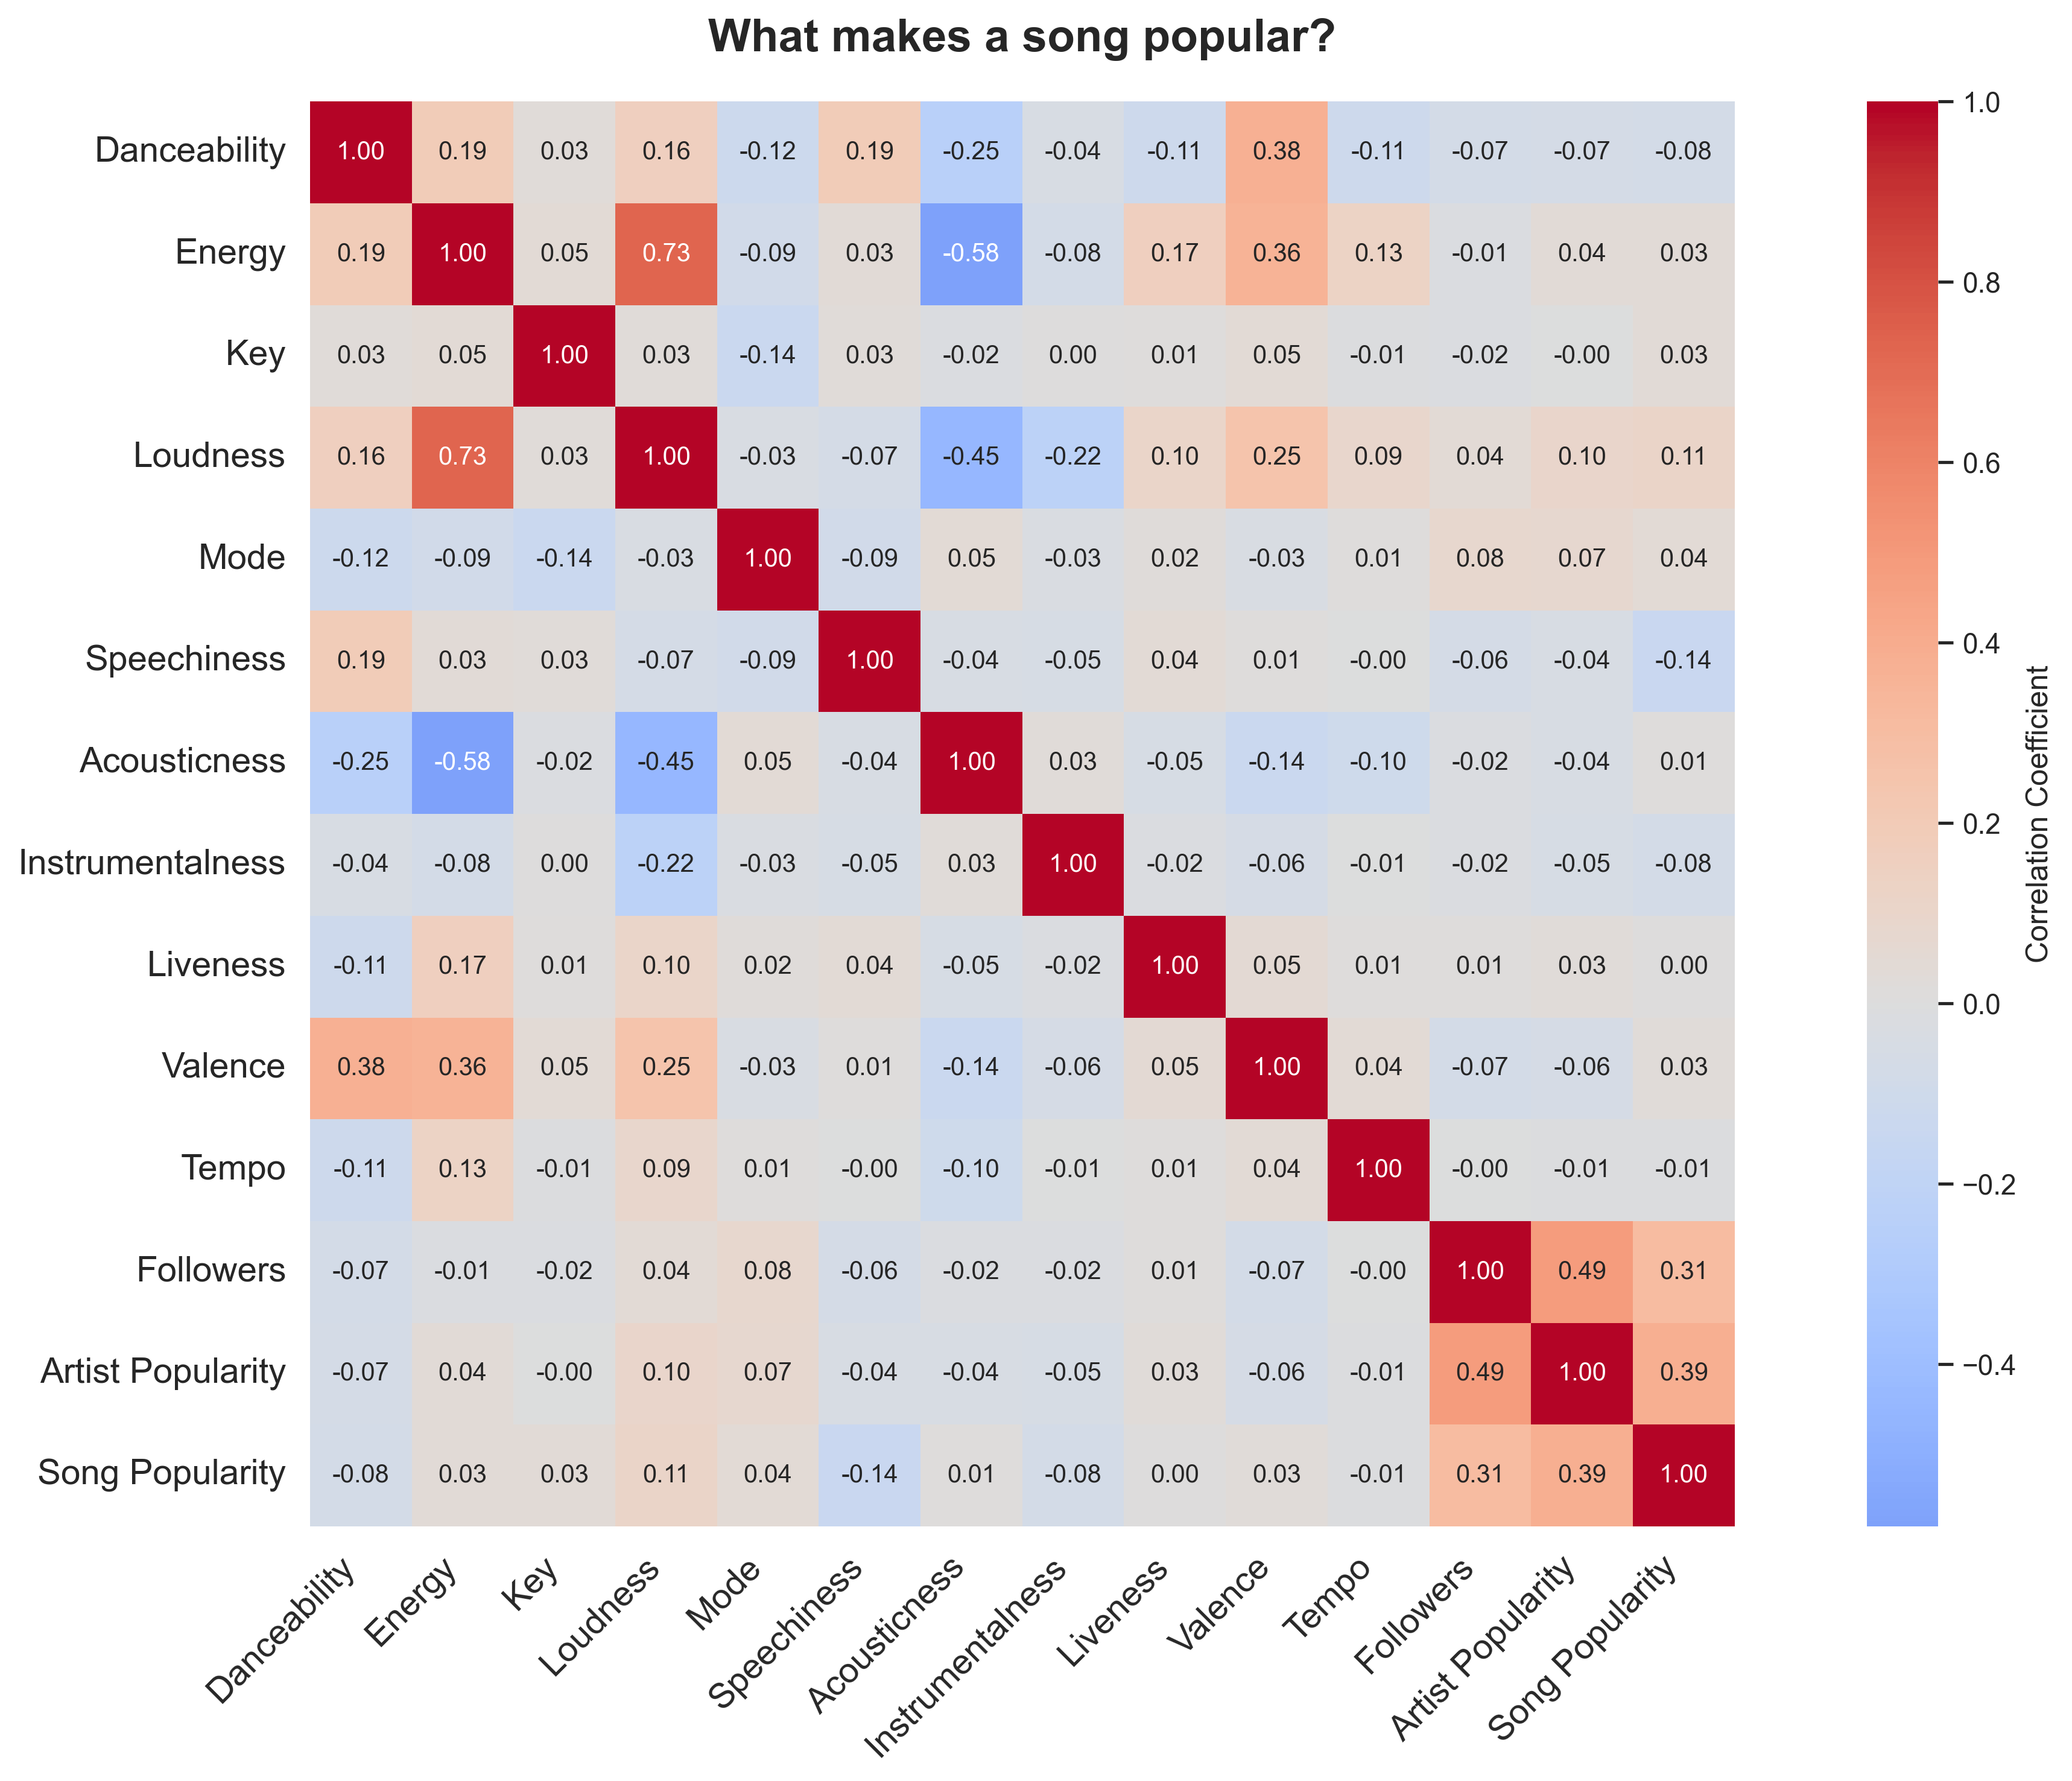

<Figure size 640x480 with 0 Axes>

In [30]:
# Retrieve the data
top_spotify_songs = sentiment_dataframes['top_spotify_songs.csv']

# Define the feature columns
feature_columns = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'followers', 'artist_popularity'
]

# Create correlation matrix
plt.figure(figsize=(15, 10), dpi=300)

# Create readable column names
readable_columns = {
    'danceability': 'Danceability',
    'energy': 'Energy', 
    'key': 'Key',
    'loudness': 'Loudness',
    'mode': 'Mode',
    'speechiness': 'Speechiness',
    'acousticness': 'Acousticness',
    'instrumentalness': 'Instrumentalness', 
    'liveness': 'Liveness',
    'valence': 'Valence',
    'tempo': 'Tempo',
    'followers': 'Followers',
    'artist_popularity': 'Artist Popularity',
    'song_popularity': 'Song Popularity'
}

# Create correlation matrix with readable column names
df_readable = top_spotify_songs[feature_columns + ['song_popularity']].copy()
df_readable.columns = [readable_columns[col] for col in df_readable.columns]
correlation_matrix = df_readable.corr()

# Create heatmap with improved styling
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True,
            cbar_kws={'label': 'Correlation Coefficient'},
            annot_kws={'size': 10})

# Customize appearance
plt.title('What makes a song popular?', pad=20, size=18, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

plt.savefig("graphs/05_what_makes_a_song_popular.png", dpi=300, bbox_inches='tight')

## Feature Importance
**Originator: Shivam Tyagi**

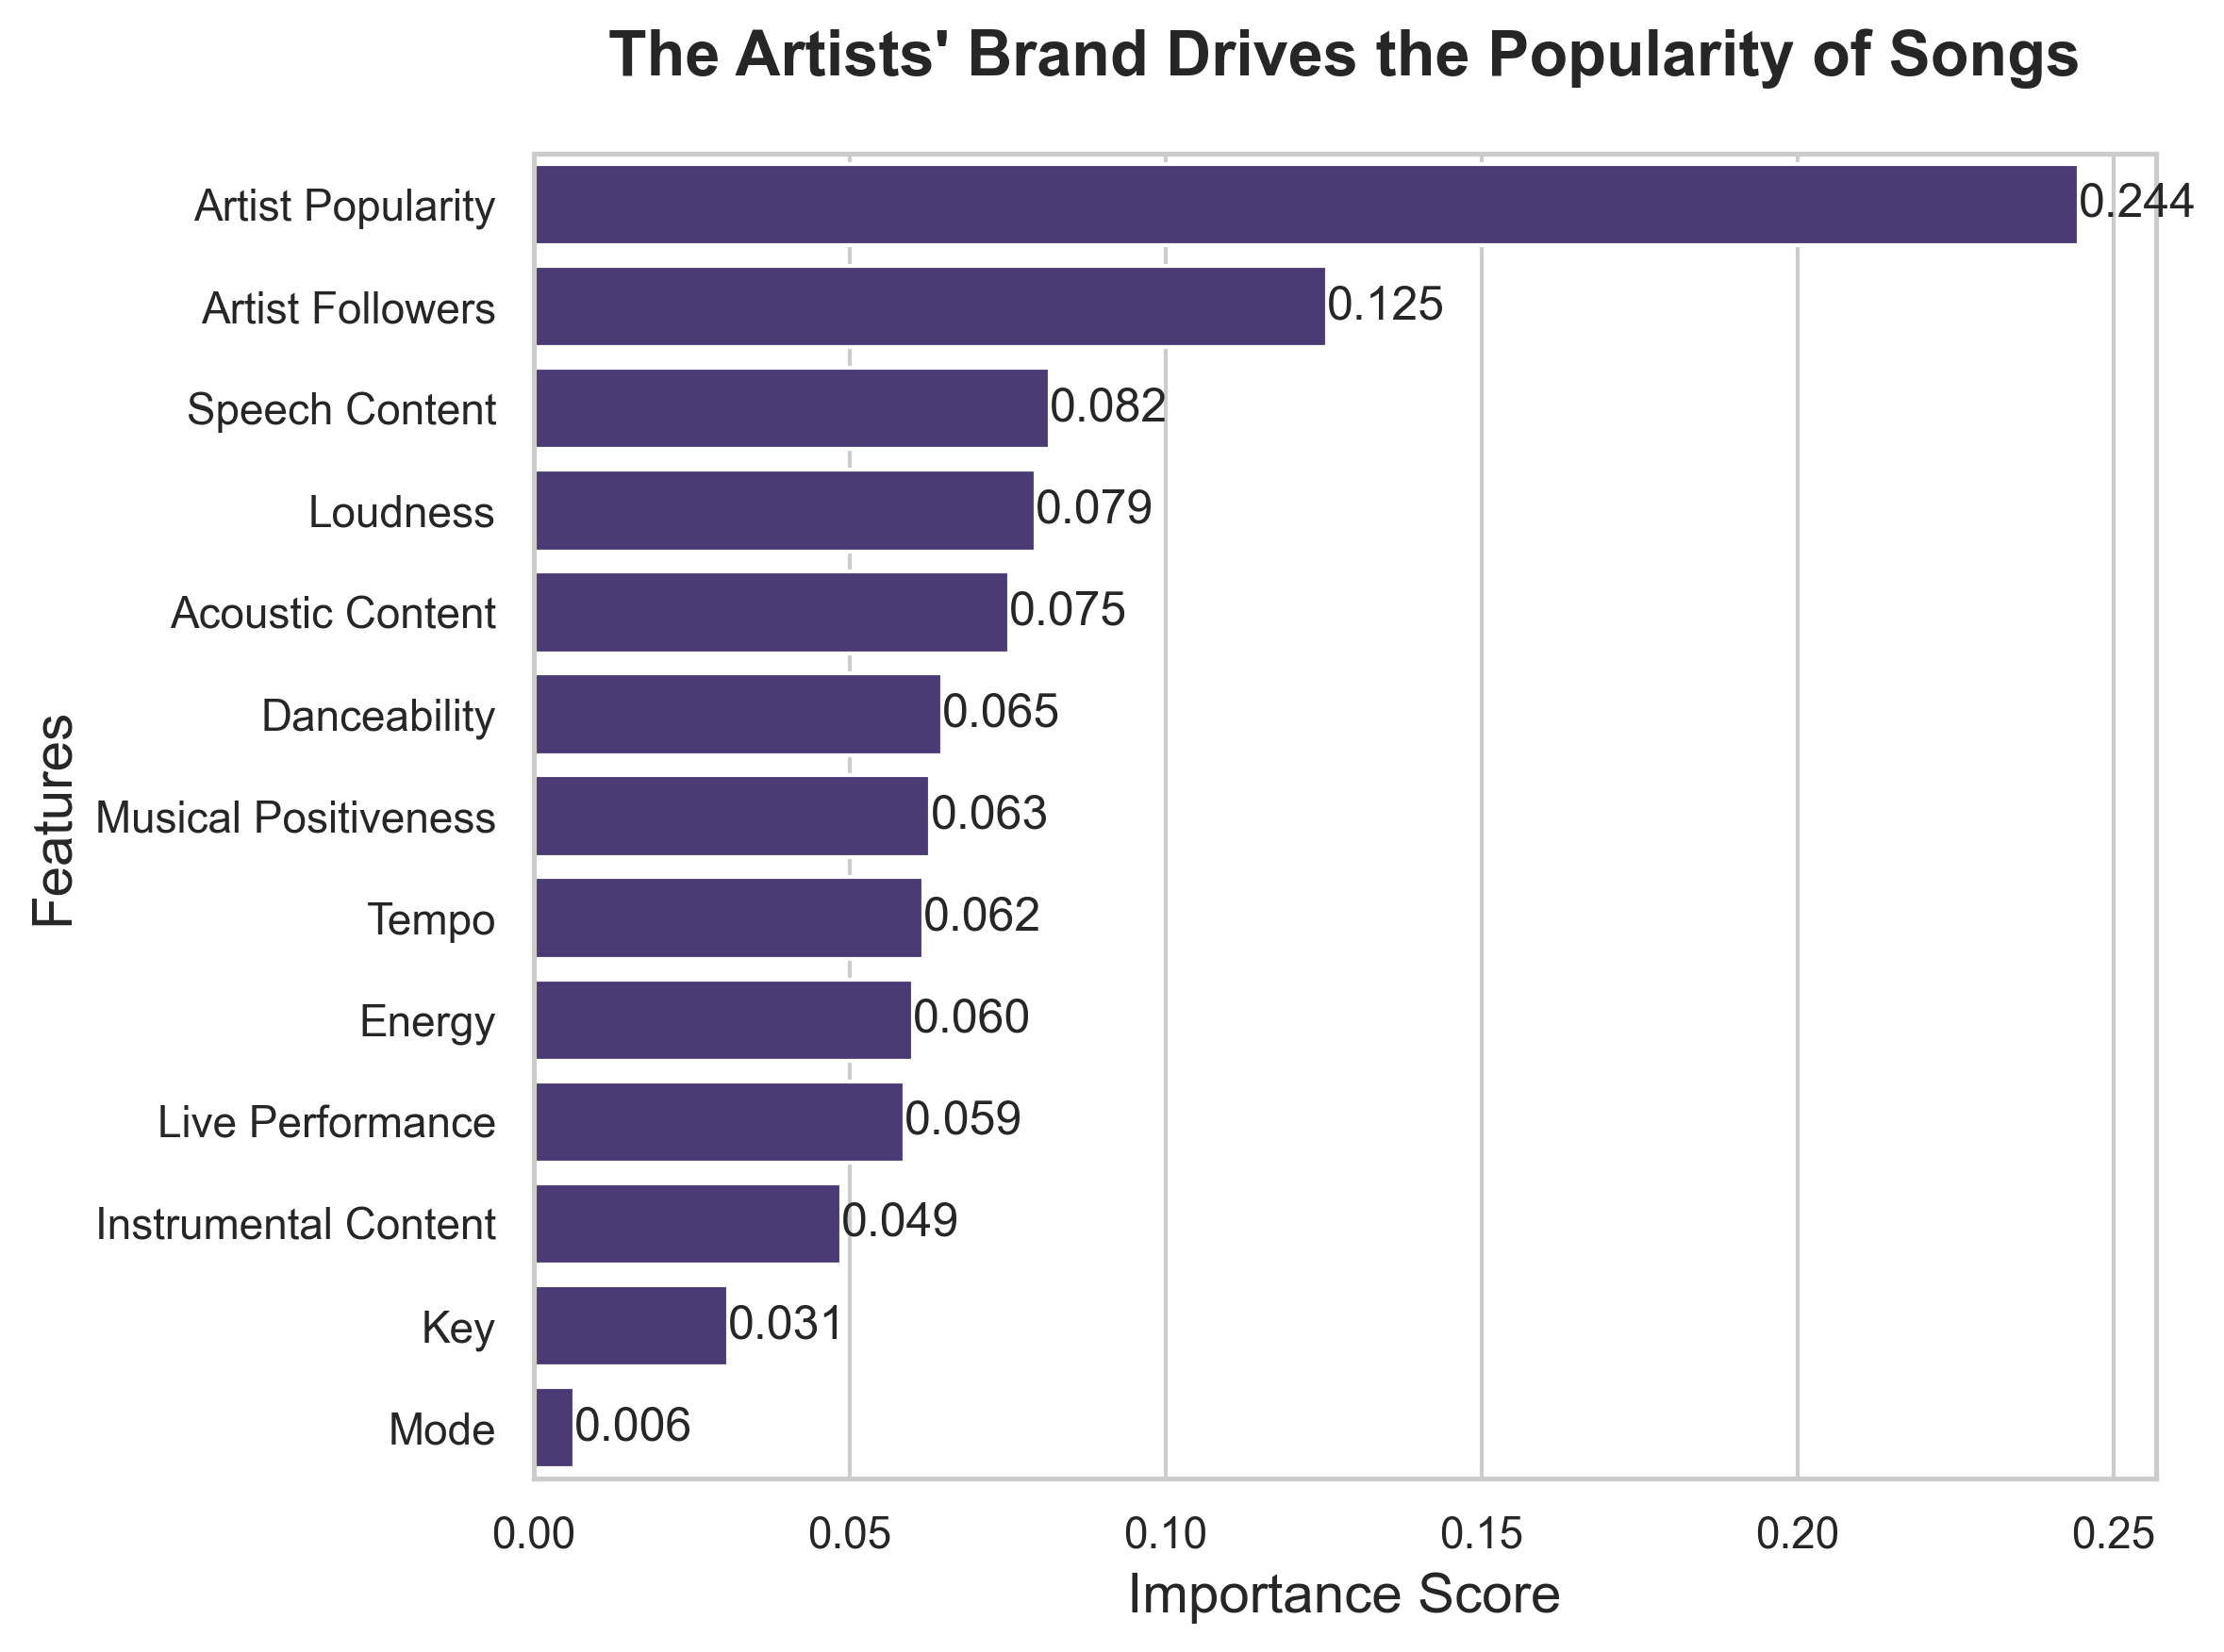


Feature Importances:
----------------------------------------
Feature                     Importance
----------------------------------------
Artist Popularity               0.2444
Artist Followers                0.1255
Speech Content                  0.0816
Loudness                        0.0795
Acoustic Content                0.0753
Danceability                    0.0646
Musical Positiveness            0.0628
Tempo                           0.0616
Energy                          0.0600
Live Performance                0.0587
Instrumental Content            0.0487
Key                             0.0308
Mode                            0.0064
----------------------------------------


In [31]:
# Prepare the features
feature_columns = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'followers', 'artist_popularity'
]

X = top_spotify_songs[feature_columns]
y = top_spotify_songs['song_popularity']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("viridis")

# Clean up feature names for display
feature_display_names = importances['feature'].map({
    'danceability': 'Danceability',
    'energy': 'Energy', 
    'key': 'Key',
    'loudness': 'Loudness',
    'mode': 'Mode',
    'speechiness': 'Speech Content',
    'acousticness': 'Acoustic Content',
    'instrumentalness': 'Instrumental Content', 
    'liveness': 'Live Performance',
    'valence': 'Musical Positiveness',
    'tempo': 'Tempo',
    'followers': 'Artist Followers',
    'artist_popularity': 'Artist Popularity'
})

ax = sns.barplot(y=feature_display_names, x=importances['importance'])
plt.title("The Artists' Brand Drives the Popularity of Songs", pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Add value labels on the bars
for i, v in enumerate(importances['importance']):
    ax.text(v, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.savefig("graphs/06_Feature_Importance.png", dpi=300, bbox_inches='tight')
plt.show()

# Print feature importances
print("\nFeature Importances:")
print("-" * 40)
print(f"{'Feature':<25} {'Importance':>12}")
print("-" * 40)
for idx, row in importances.iterrows():
    display_name = feature_display_names[idx]
    print(f"{display_name:<25} {row['importance']:>12.4f}")
print("-" * 40)


## Artist Productivity and Popularity
**Originator: Shivam Tyagi**

Error categorizing instrumentalness: Bin labels must be one fewer than the number of bin edges


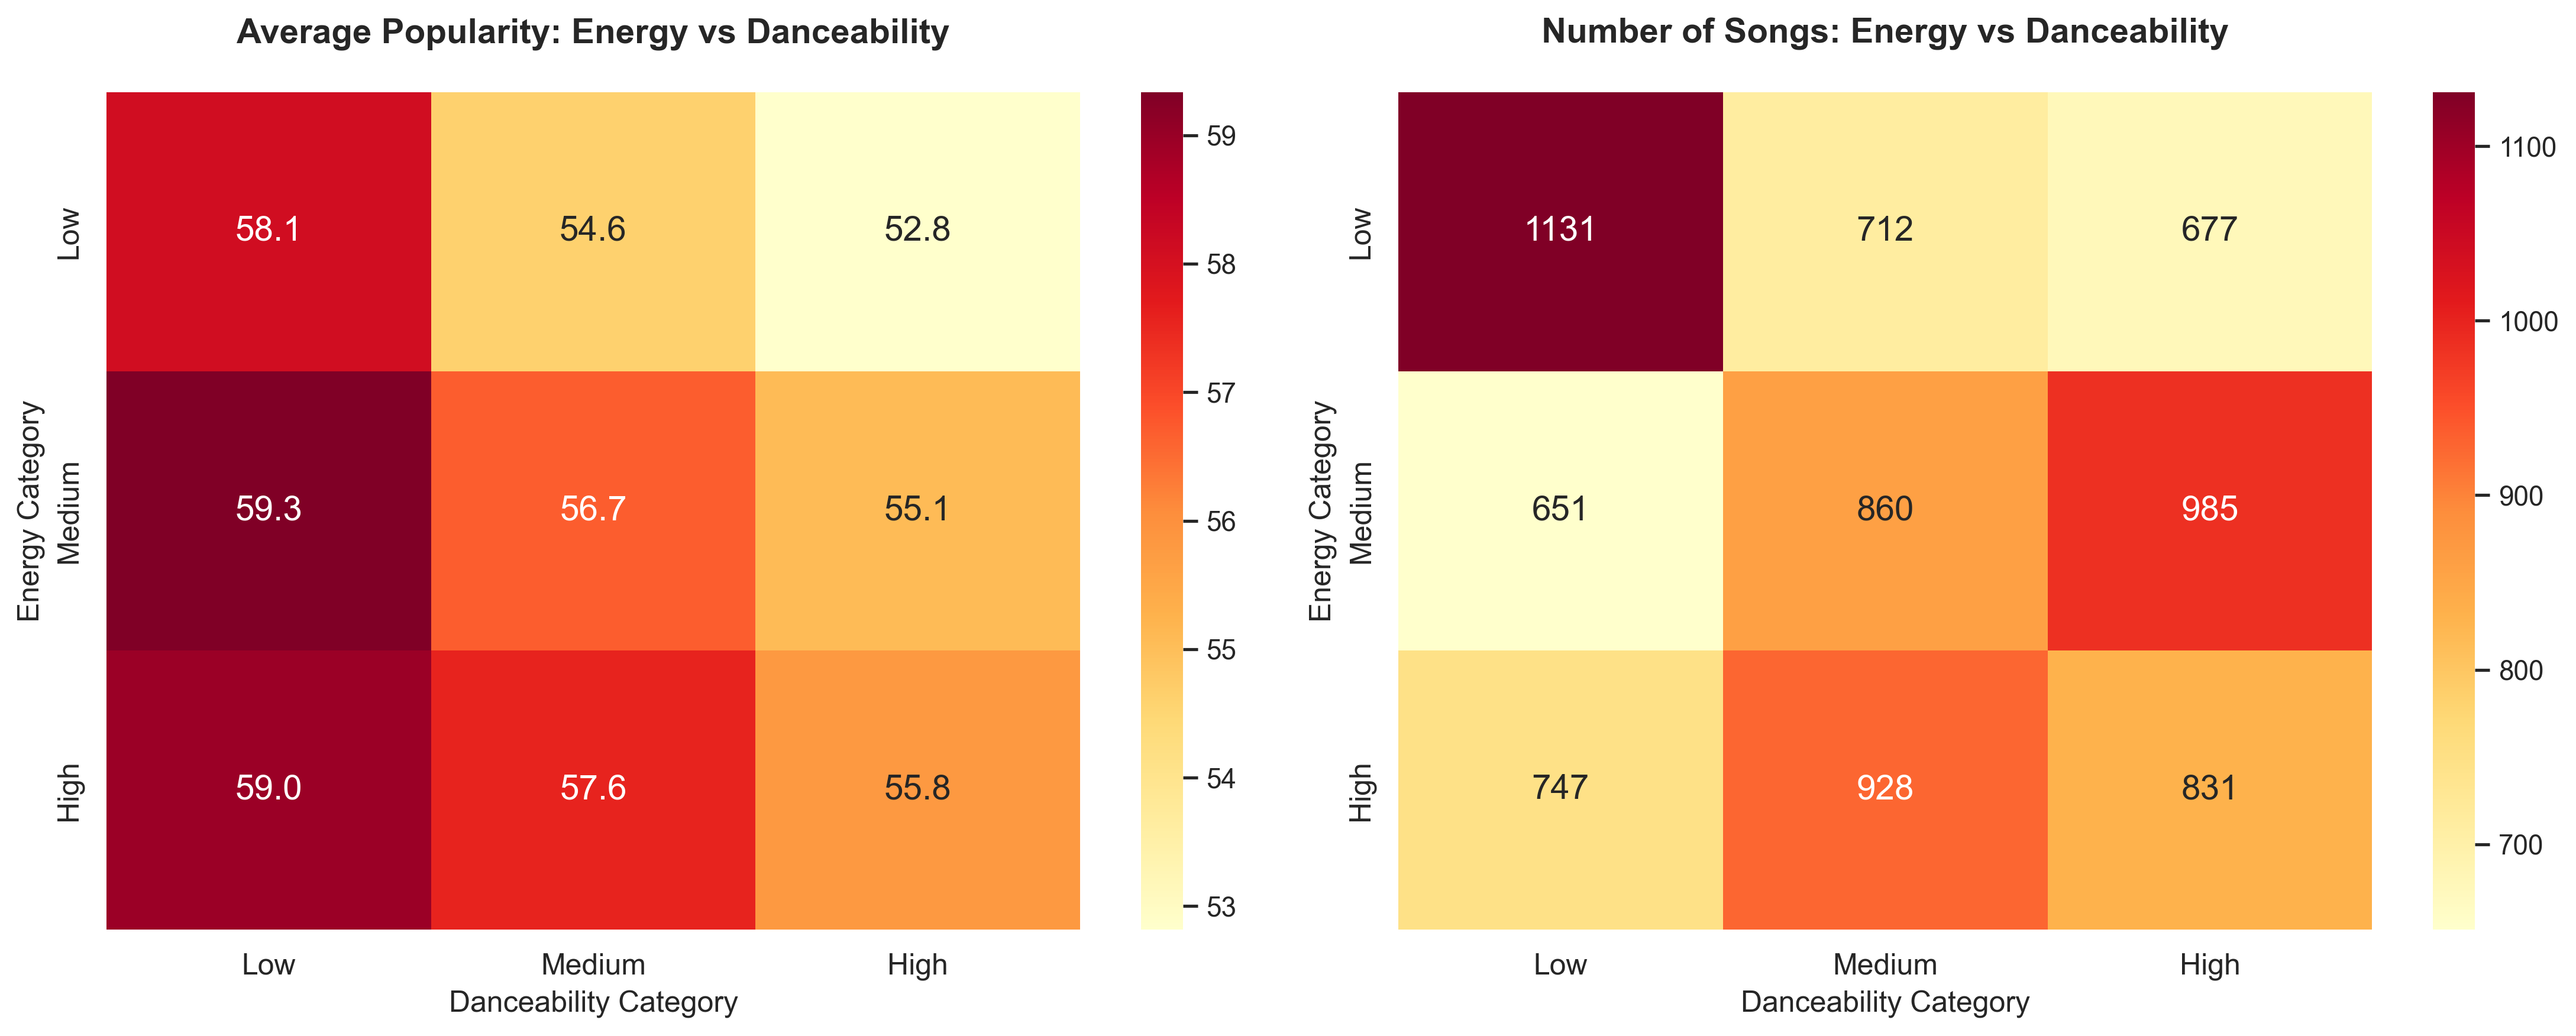


Top combinations of energy and danceability:
                                      song_popularity      
                                                 mean count
energy_category danceability_category                      
Medium          Low                             59.33   651
High            Low                             58.95   747
Low             Low                             58.11  1131
High            Medium                          57.58   928
Medium          Medium                          56.70   860

Rare but successful combinations of energy and danceability:
                                      song_popularity      
                                                 mean count
energy_category danceability_category                      
Medium          Low                             59.33   651




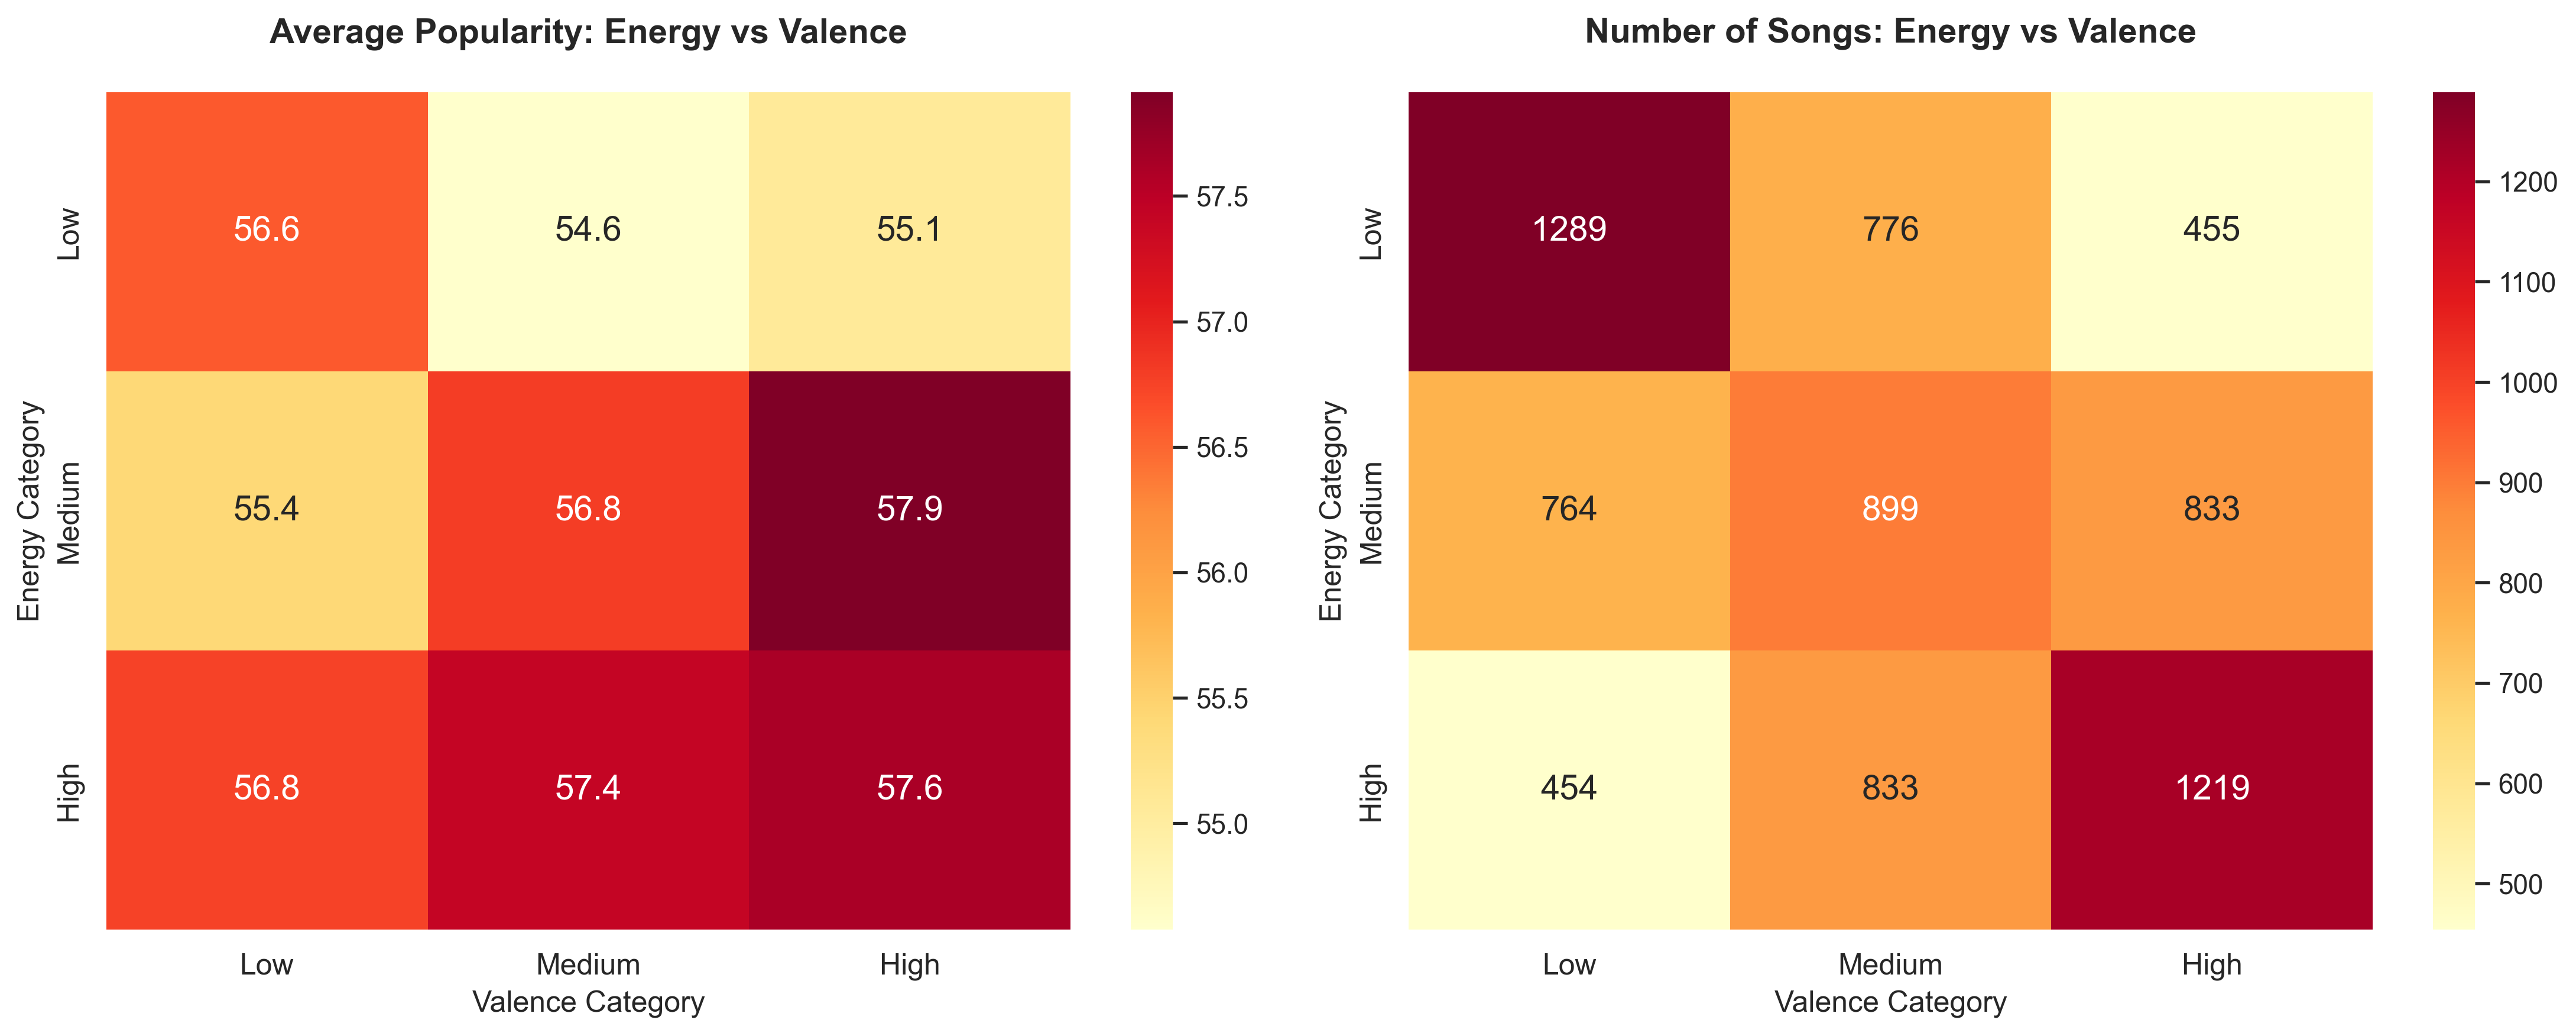


Top combinations of energy and valence:
                                 song_popularity      
                                            mean count
energy_category valence_category                      
Medium          High                       57.91   833
High            High                       57.62  1219
                Medium                     57.42   833
Medium          Medium                     56.80   899
High            Low                        56.76   454




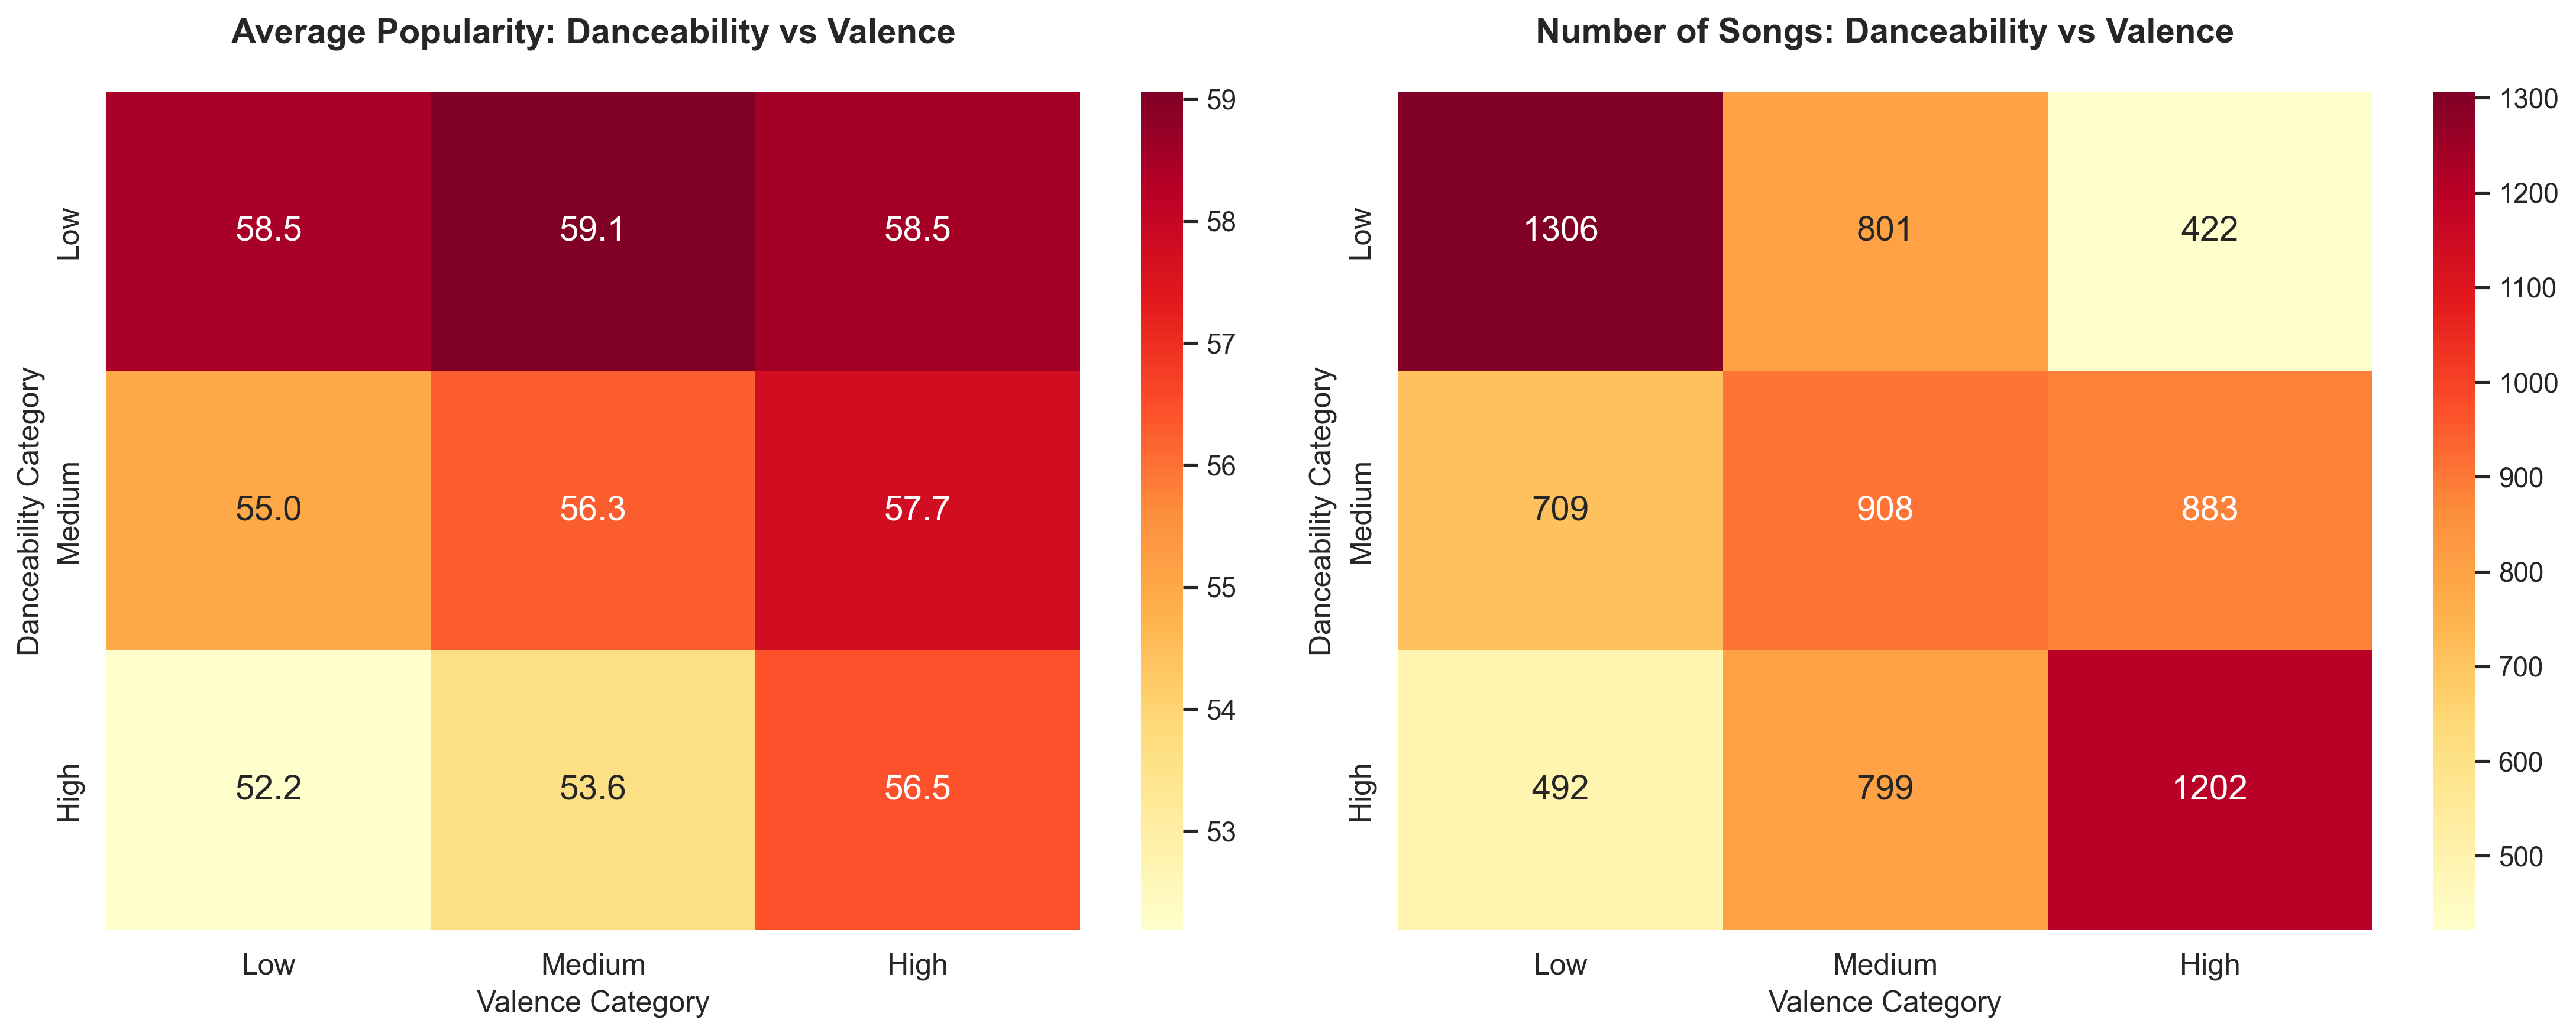


Top combinations of danceability and valence:
                                       song_popularity      
                                                  mean count
danceability_category valence_category                      
Low                   Medium                     59.06   801
                      High                       58.53   422
                      Low                        58.49  1306
Medium                High                       57.74   883
High                  High                       56.45  1202

Rare but successful combinations of danceability and valence:
                                       song_popularity      
                                                  mean count
danceability_category valence_category                      
Low                   High                       58.53   422




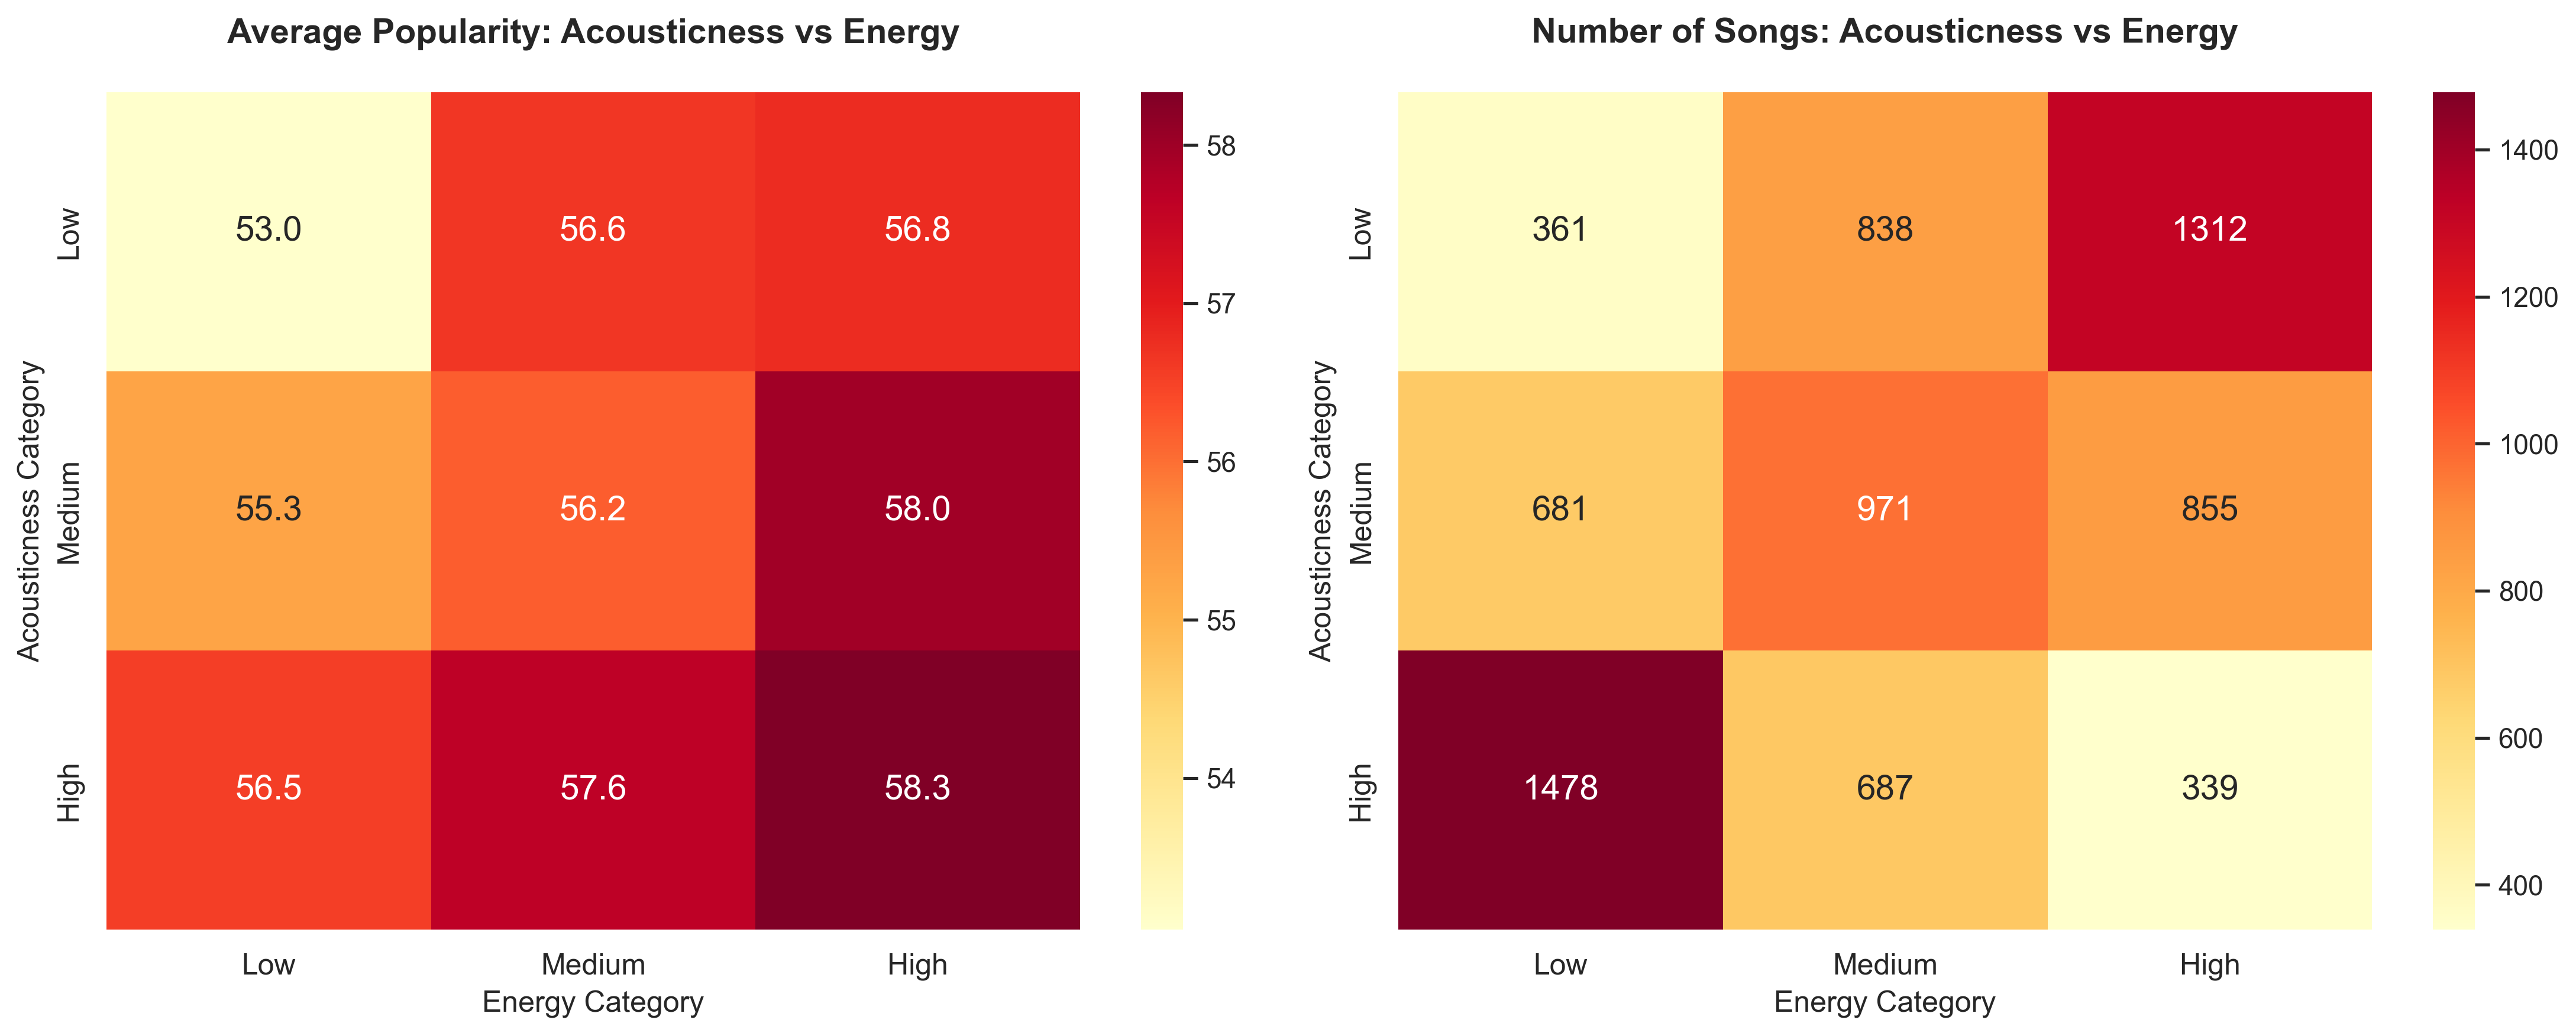


Top combinations of acousticness and energy:
                                      song_popularity      
                                                 mean count
acousticness_category energy_category                      
High                  High                      58.33   339
Medium                High                      57.98   855
High                  Medium                    57.65   687
Low                   High                      56.78  1312
                      Medium                    56.64   838

Rare but successful combinations of acousticness and energy:
                                      song_popularity      
                                                 mean count
acousticness_category energy_category                      
High                  High                      58.33   339




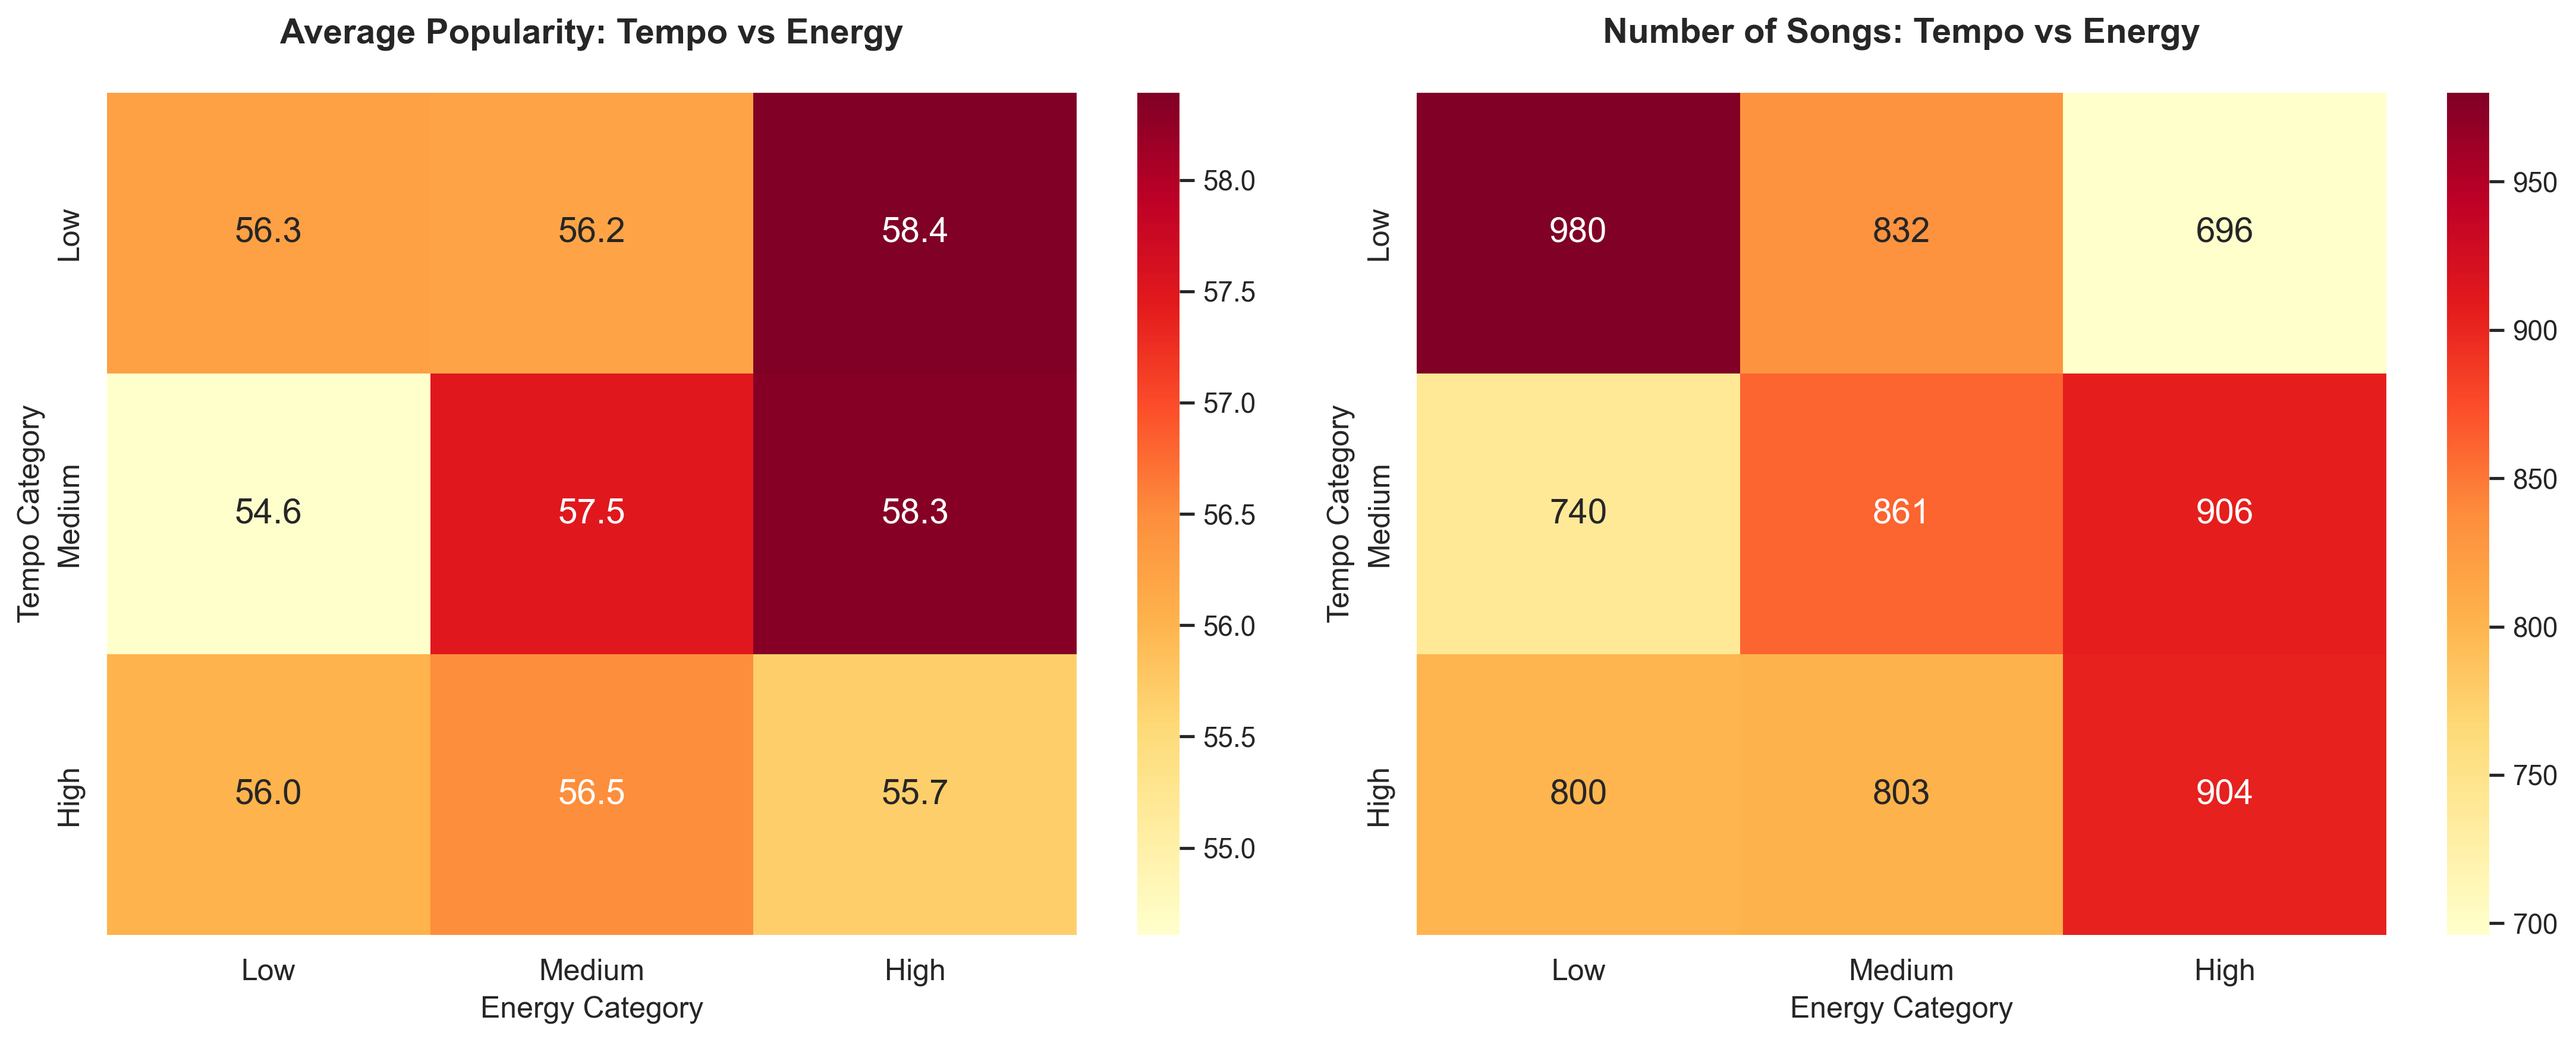


Top combinations of tempo and energy:
                               song_popularity      
                                          mean count
tempo_category energy_category                      
Low            High                      58.39   696
Medium         High                      58.34   906
               Medium                    57.48   861
High           Medium                    56.50   803
Low            Low                       56.26   980

Rare but successful combinations of tempo and energy:
                               song_popularity      
                                          mean count
tempo_category energy_category                      
Low            High                      58.39   696



Most successful three-way combinations:
                                                       song_popularity      
                                                                  mean count
energy_category danceability_category valence_category                   

In [32]:
# First, let's categorize features into Low/Medium/High
features_to_combine = [
    'danceability', 'energy', 'valence', 'tempo', 
    'acousticness', 'instrumentalness'
]

# Create categories for each feature
for feature in features_to_combine:
    try:
        top_spotify_songs[f'{feature}_category'] = pd.qcut(
            top_spotify_songs[feature], 
            q=3, 
            labels=['Low', 'Medium', 'High'],
            duplicates='drop'
        )
    except ValueError as e:
        print(f"Error categorizing {feature}: {e}")

# Let's look at pairs of features first
# We'll focus on some interesting combinations
feature_pairs = [
    ('energy', 'danceability'),
    ('energy', 'valence'),
    ('danceability', 'valence'),
    ('acousticness', 'energy'),
    ('tempo', 'energy')
]

# Create visualizations for each pair
for feature1, feature2 in feature_pairs:
    # Create a pivot table of average popularity for each combination
    pivot = pd.pivot_table(
        top_spotify_songs,
        values='song_popularity',
        index=f'{feature1}_category',
        columns=f'{feature2}_category',
        aggfunc=['mean', 'count'],
        observed=False  # Retain current behavior to avoid FutureWarning
    )
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
    
    # Plot average popularity heatmap
    sns.heatmap(pivot['mean'], annot=True, fmt='.1f', ax=ax1, cmap='YlOrRd', annot_kws={'size': 14})
    ax1.set_title(f'Average Popularity: {feature1.capitalize()} vs {feature2.capitalize()}', 
                 fontsize=14, pad=20, weight='bold')
    ax1.tick_params(labelsize=12)
    ax1.set_xlabel(f'{feature2.capitalize()} Category', fontsize=12)
    ax1.set_ylabel(f'{feature1.capitalize()} Category', fontsize=12)
    
    # Plot count heatmap (to identify rare combinations)
    sns.heatmap(pivot['count'], annot=True, fmt='d', ax=ax2, cmap='YlOrRd', annot_kws={'size': 14})
    ax2.set_title(f'Number of Songs: {feature1.capitalize()} vs {feature2.capitalize()}',
                 fontsize=14, pad=20, weight='bold')
    ax2.tick_params(labelsize=12)
    ax2.set_xlabel(f'{feature2.capitalize()} Category', fontsize=12)
    ax2.set_ylabel(f'{feature1.capitalize()} Category', fontsize=12)

    plt.tight_layout()
    plt.savefig(f"graphs/07_artist_productivity_and_popularity_{feature1}_{feature2}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print the most successful combinations
    print(f"\nTop combinations of {feature1} and {feature2}:")
    combinations = top_spotify_songs.groupby(
        [f'{feature1}_category', f'{feature2}_category'],
        observed=False  # Retain current behavior to avoid FutureWarning
    ).agg({
        'song_popularity': ['mean', 'count']
    }).round(2)
    
    combinations = combinations.sort_values(('song_popularity', 'mean'), ascending=False)
    print(combinations.head())
    
    # Identify rare but successful combinations
    # Define rare as bottom 25% by count but top 25% by popularity
    count_threshold = combinations[('song_popularity', 'count')].quantile(0.25)
    popularity_threshold = combinations[('song_popularity', 'mean')].quantile(0.75)
    
    rare_successful = combinations[
        (combinations[('song_popularity', 'count')] <= count_threshold) &
        (combinations[('song_popularity', 'mean')] >= popularity_threshold)
    ]
    
    if not rare_successful.empty:
        print(f"\nRare but successful combinations of {feature1} and {feature2}:")
        print(rare_successful)
    print("\n" + "="*50 + "\n")

# Let's also look at three-way combinations for the most interesting features
features_three = ['energy', 'danceability', 'valence']

# Create a pivot table for three-way combinations
three_way = top_spotify_songs.groupby(
    [f'{f}_category' for f in features_three],
    observed=False  # Retain current behavior to avoid FutureWarning
).agg({
    'song_popularity': ['mean', 'count']
}).round(2)

# Sort by popularity
print("\nMost successful three-way combinations:")
print(three_way.sort_values(('song_popularity', 'mean'), ascending=False).head(10))

# Identify rare but successful three-way combinations
count_threshold = three_way[('song_popularity', 'count')].quantile(0.25)
popularity_threshold = three_way[('song_popularity', 'mean')].quantile(0.75)

rare_successful_three = three_way[
    (three_way[('song_popularity', 'count')] <= count_threshold) &
    (three_way[('song_popularity', 'mean')] >= popularity_threshold)
]

print("\nRare but successful three-way combinations:")
print(rare_successful_three)

## Energy, Danceability & Valence (Three-Way Combinations):
**Originator: Shivam Tyagi**

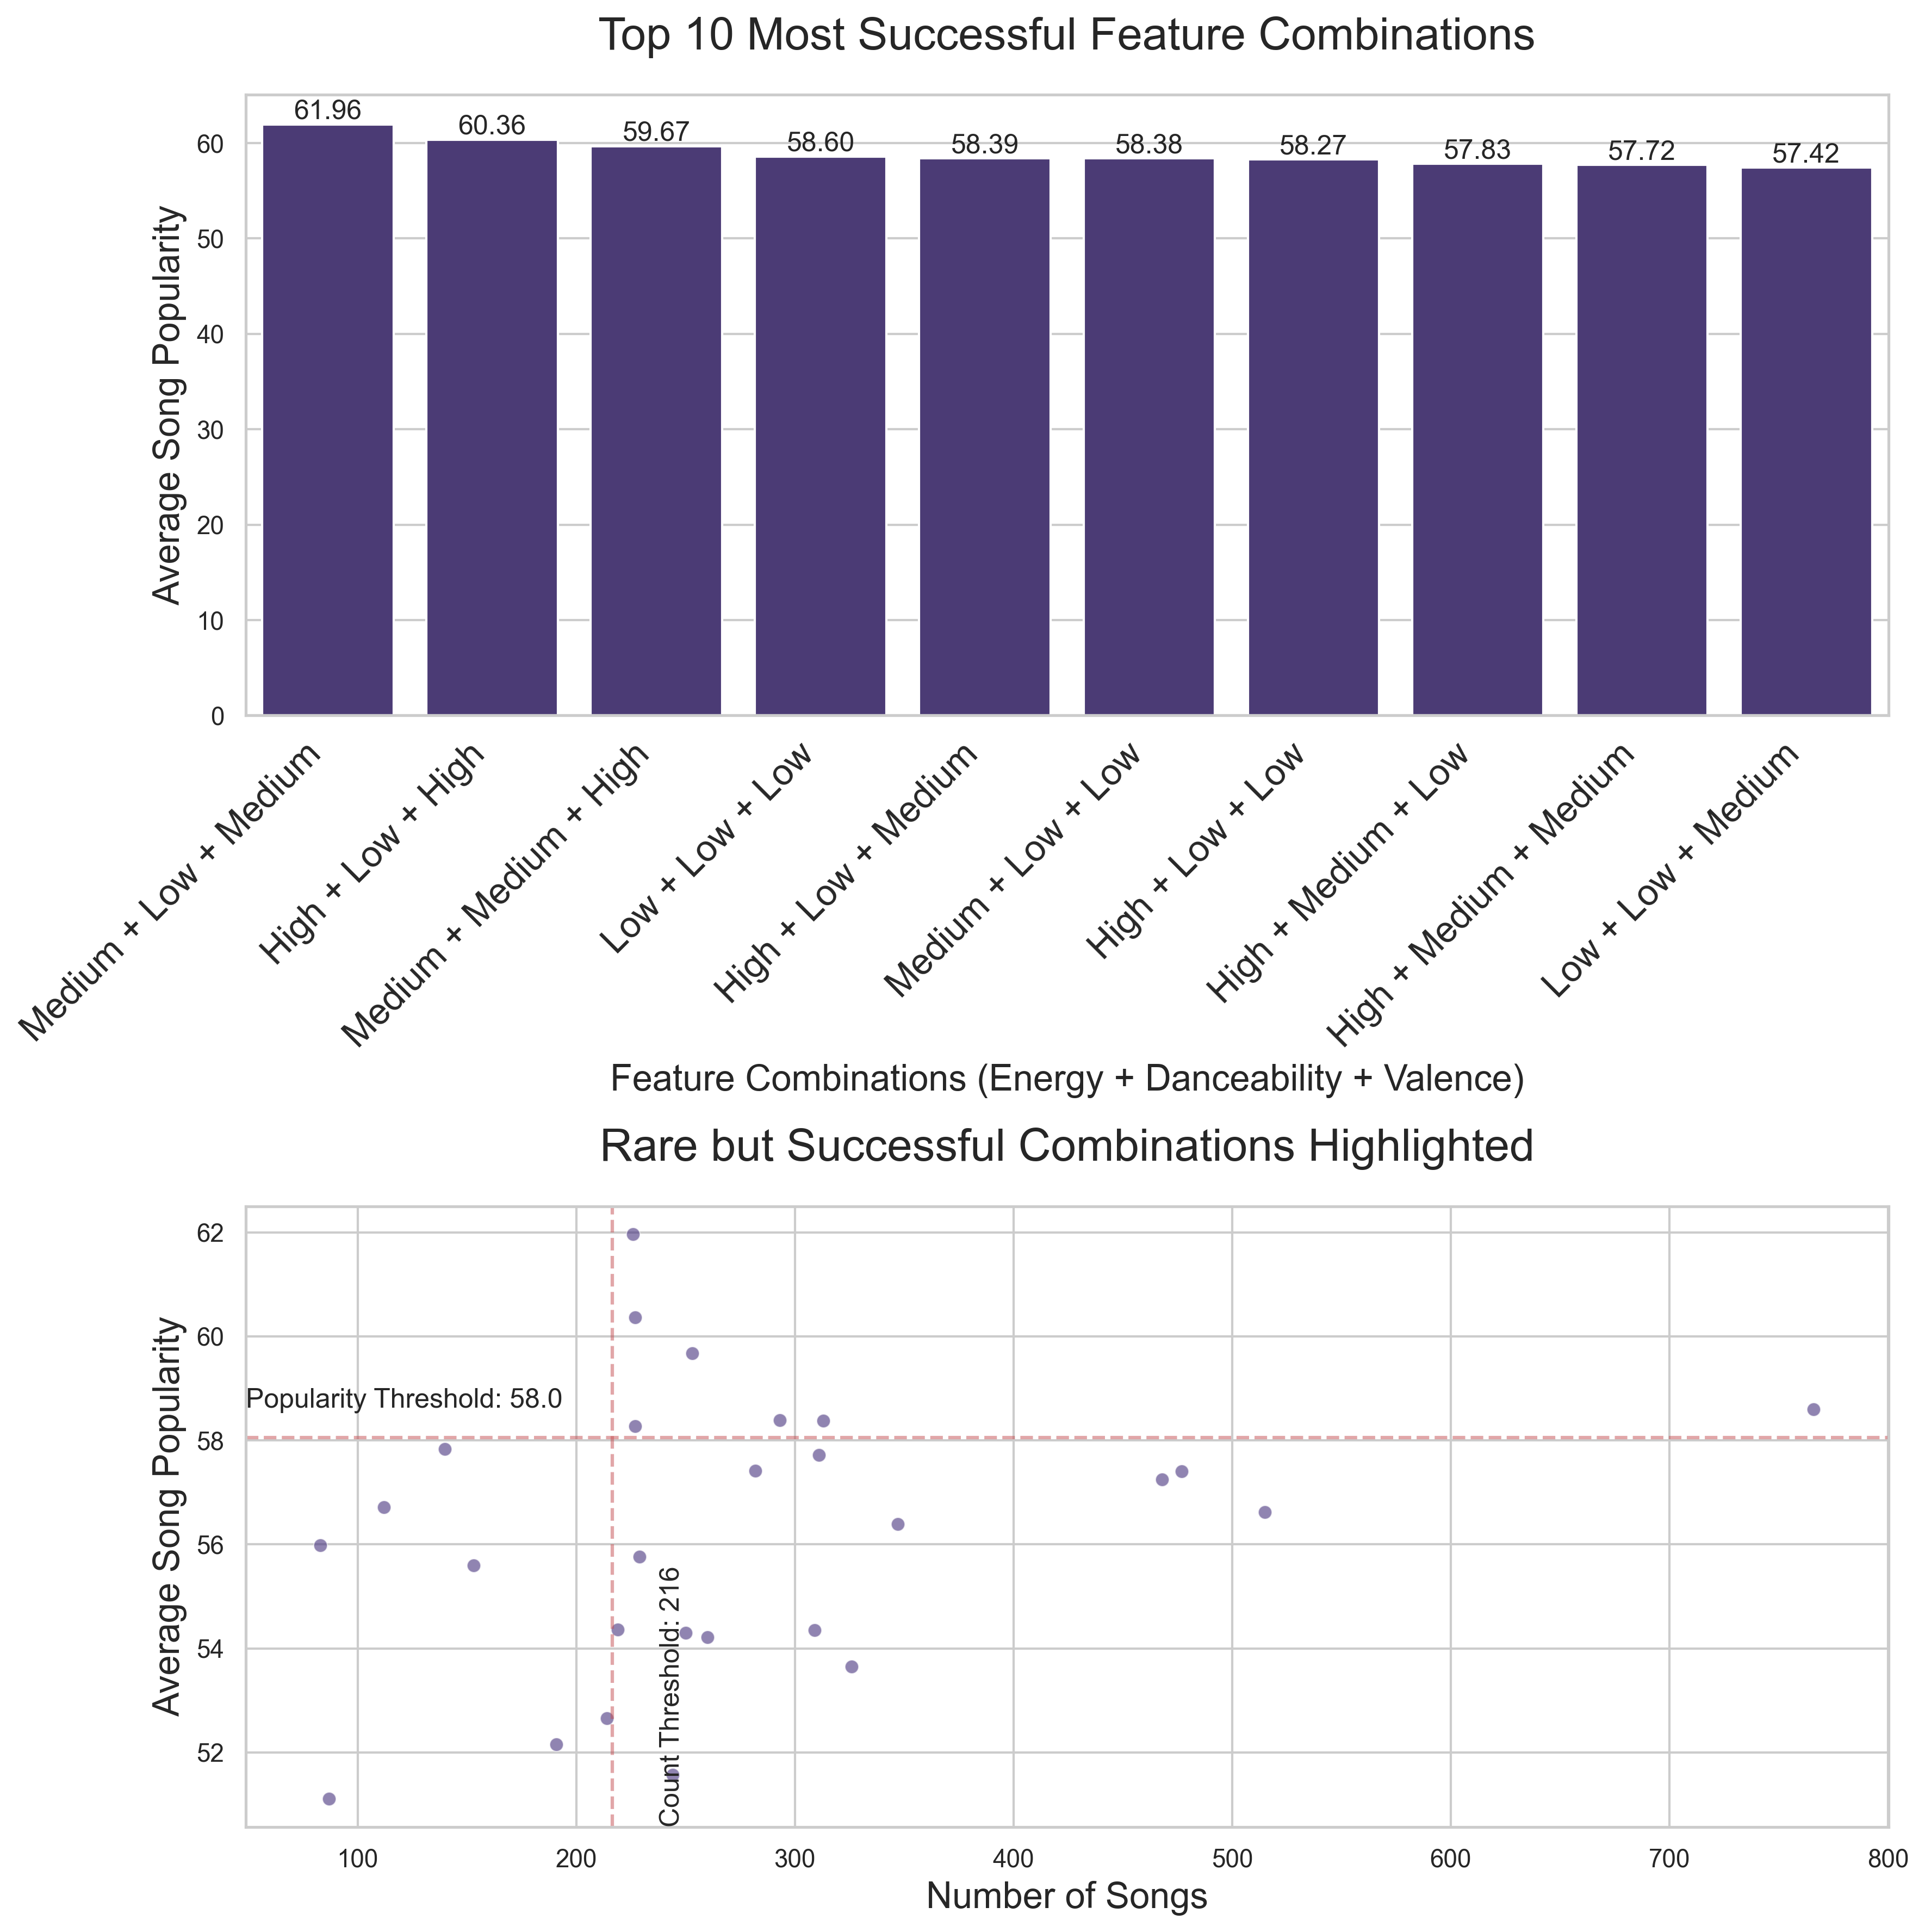


Most successful three-way combinations:
                                                       song_popularity      
                                                                  mean count
energy_category danceability_category valence_category                      
Medium          Low                   Medium                     61.96   226
High            Low                   High                       60.36   227
Medium          Medium                High                       59.67   253
Low             Low                   Low                        58.60   766
High            Low                   Medium                     58.39   293
Medium          Low                   Low                        58.38   313
High            Low                   Low                        58.27   227
                Medium                Low                        57.83   140
                                      Medium                     57.72   311
Low             Low                

In [33]:
# Create visualizations for three-way combinations analysis
plt.figure(figsize=(12, 12), dpi=300)
sns.set_style("whitegrid")
sns.set_palette("viridis")

# Plot 1: Most successful combinations
plt.subplot(2, 1, 1)
top_10_combinations = three_way.sort_values(('song_popularity', 'mean'), ascending=False).head(10)

# Create labels for x-axis by converting categorical indices to strings
x_labels = [f"{e} + {d} + {v}" for e,d,v in zip(
    top_10_combinations.index.get_level_values(0).astype(str),
    top_10_combinations.index.get_level_values(1).astype(str), 
    top_10_combinations.index.get_level_values(2).astype(str)
)]

# Create bar plot
sns.barplot(
    x=x_labels,
    y=top_10_combinations[('song_popularity', 'mean')],
    ax=plt.gca()
)

# Add value labels on top of bars
for i, v in enumerate(top_10_combinations[('song_popularity', 'mean')]):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right', fontsize=16)
plt.title('Top 10 Most Successful Feature Combinations', pad=20, fontsize=20)
plt.xlabel('Feature Combinations (Energy + Danceability + Valence)', fontsize=16)
plt.ylabel('Average Song Popularity', fontsize=16)

# Plot 2: Rare but successful combinations
plt.subplot(2, 1, 2)
sns.scatterplot(
    data=three_way.reset_index(),
    x=('song_popularity', 'count'),
    y=('song_popularity', 'mean'),
    alpha=0.6
)

# Highlight rare but successful combinations
plt.axvline(x=count_threshold, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=popularity_threshold, color='r', linestyle='--', alpha=0.5)

plt.title('Rare but Successful Combinations Highlighted', pad=20, fontsize=20)
plt.xlabel('Number of Songs', fontsize=16)
plt.ylabel('Average Song Popularity', fontsize=16)

# Add text annotations for thresholds
plt.text(count_threshold*1.1, plt.ylim()[0], f'Count Threshold: {count_threshold:.0f}', 
         rotation=90, verticalalignment='bottom')
plt.text(plt.xlim()[0], popularity_threshold*1.01, 
         f'Popularity Threshold: {popularity_threshold:.1f}')

plt.tight_layout()
plt.savefig("graphs/08_successful_feature_combinations.png", dpi=300, bbox_inches='tight')
plt.show()

# Print the numerical results as well
print("\nMost successful three-way combinations:")
print(top_10_combinations)

print("\nRare but successful three-way combinations:")
print(rare_successful_three)